# CNN and RNN

Convolutional and Recurrent Neural Networks for images and signals (feat. TensorFlow and PyTorch)

In [1]:
import numpy as np
import pandas as pd	
import datetime as dt
import copy
from collections import defaultdict
from matplotlib import pyplot as plt
from tabulate import tabulate
from itertools import islice
from pathlib import Path
import cloudpickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor, LGBMClassifier

import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision

In [2]:
np.random.seed(42)

In [3]:
# Limit TensorFlow GPU memory usage
gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print(f'Detected GPU: {gpu_devices}')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    print(f'TF2 GPU memory usage has been restricted')
else:
    print('No GPU detected')

Detected GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TF2 GPU memory usage has been restricted


In [4]:
# Create TensorFlow Board (http://127.0.0.1:6006)
# %load_ext tensorboard
# %tensorboard --logdir logs/fit --port=6006

## MNIST Dataset

- http://yann.lecun.com/exdb/mnist/
- https://www.kaggle.com/c/digit-recognizer/discussion/61480

In [5]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Test vs train lenght: 60000 vs 10000
Image size: (28, 28)
Image pixel range: 0 - 255
Classes: [0 1 2 3 4 5 6 7 8 9]


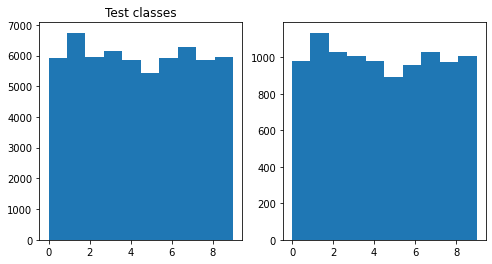

In [6]:
print(f'Test vs train lenght: {len(x_train)} vs {len(x_test)}')
print(f'Image size: {x_train[0].shape}')
print(f'Image pixel range: {x_train[0].min()} - {x_train[0].max()}')
print(f'Classes: {np.unique(y_train)}')
fix, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(y_train)
ax[0].set_title('Train classes')
ax[1].hist(y_test)
ax[0].set_title('Test classes')
_=_

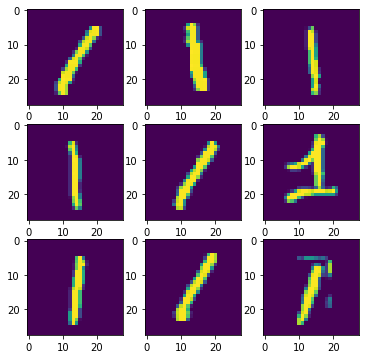

In [7]:
def show_mnist_digit(digit):
    count = 0
    i = 0
    fix, ax = plt.subplots(3, 3, figsize=(6, 6))
    while count < 3*3:
        if y_train[i] == digit:
            ax.ravel()[count].imshow(x_train[i])
            count += 1
        i += 1
        
show_mnist_digit(1)

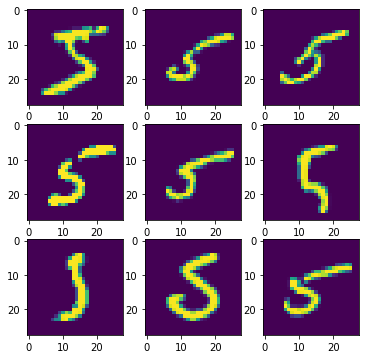

In [8]:
show_mnist_digit(5)

### TF2

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train[:, :, :, np.newaxis].astype('float32') / 255.0, y_train[:, np.newaxis]))
test_ds = tf.data.Dataset.from_tensor_slices((x_test[:, :, :, np.newaxis].astype('float32') / 255.0, y_test[:, np.newaxis]))

In [10]:
class KerasSequential(tf.keras.Sequential):
    def train_step(self, data):
        X, y = data
        with tf.GradientTape() as tape:
            y_pred = self(X, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        metric_dict = {m.name: m.result() for m in self.metrics}
        grad_norm = tf.linalg.global_norm(gradients)
        metric_dict.update({'grad_norm': grad_norm})
        return metric_dict

def train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=tuple(), grad_norm=True,
                     n_epoch=500, n_batch=128,
                     callbacks=None, board_prefix=None, device_name=None):
    with tf.device(device_name):
        k = int(len(train_ds)*0.8)
        train_ds_ = train_ds.take(k).batch(n_batch)
        val_ds_ = train_ds.skip(k).batch(n_batch)
        test_ds = test_ds.batch(n_batch)
        
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

        if board_prefix is not None:
            board_name = board_prefix + '_' + dt.datetime.now().strftime('%Y%m%dT%H%M%S')
            callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=Path('logs/tf2/') / board_name))
        train_history = model.fit(
            train_ds_,
            epochs=n_epoch, 
            validation_data=val_ds_,
            verbose=0,
            callbacks=callbacks,
        )

        _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training loss', lw=1)
        for metric in metrics:
            _ = pd.DataFrame(train_history.history)[[metric, f'val_{metric}']].plot(title=f'Training {metric}', lw=1)
        if grad_norm:
            _ = pd.DataFrame(train_history.history)[['grad_norm']].plot(title=f'Training gradient norm', lw=1)

        train_results = model.evaluate(train_ds_)
        test_results = model.evaluate(test_ds)
        for i, metric in enumerate(metrics):
            print(f'Train {metric} {train_results[i+1]:.3f}')
            print(f'Test {metric} {test_results[i+1]:.3f}')
            
def get_lr_scheduler(decay_rate, first_epoch=0, last_epoch=1000):
    def sheduler_fun(epoch, lr):
        if (epoch > first_epoch) and (epoch < last_epoch):
            return lr * decay_rate
        else:
            return lr
    return sheduler_fun

#### Feedforward

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
79/79 [==============================] - 0s 1ms/step - loss: 0.0743 - accuracy: 0.9791
Train accuracy 0.996
Test accuracy 0.979
CPU times: user 3min 22s, sys: 32 s, total: 3min 54s
Wall time: 2min 32s


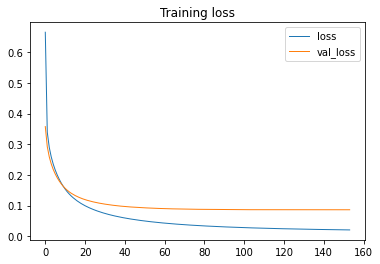

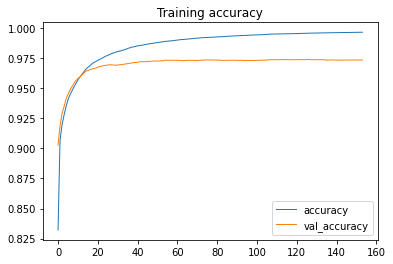

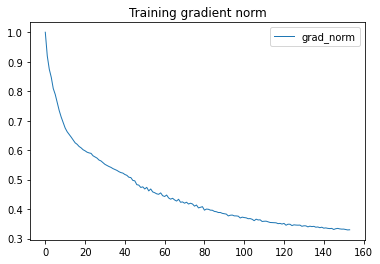

In [11]:
%%time
# Feedforward
model = KerasSequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'], 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_mlp',
)

#### CNN

79/79 [==============================] - 0s 2ms/step - loss: 0.0763 - accuracy: 0.9775
Train accuracy 0.993
Test accuracy 0.978
CPU times: user 2min 58s, sys: 46.5 s, total: 3min 45s
Wall time: 2min 27s


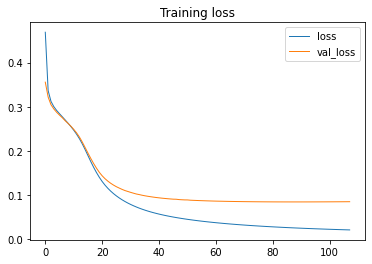

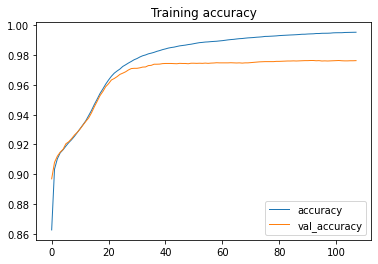

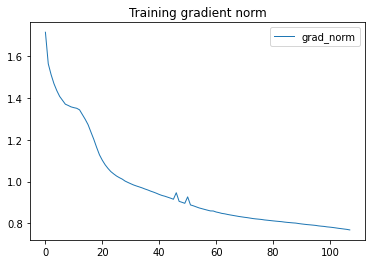

In [11]:
%%time
# CNN 1
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn1',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0609 - accuracy: 0.9812
Train accuracy 0.994
Test accuracy 0.981
CPU times: user 2min 26s, sys: 32.2 s, total: 2min 58s
Wall time: 2min 1s


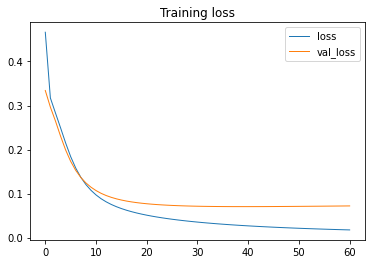

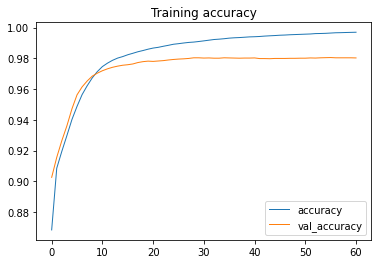

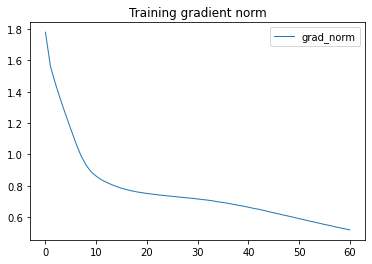

In [12]:
%%time
# CNN 2 (increase number of filters)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn2',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9808
Train accuracy 0.990
Test accuracy 0.981
CPU times: user 1min 34s, sys: 24.6 s, total: 1min 59s
Wall time: 1min 17s


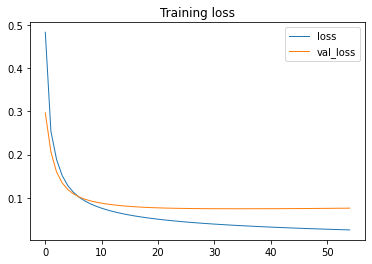

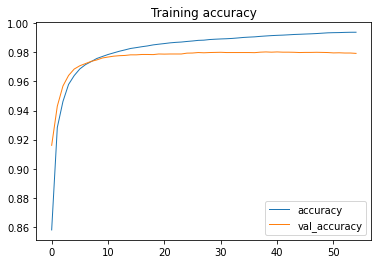

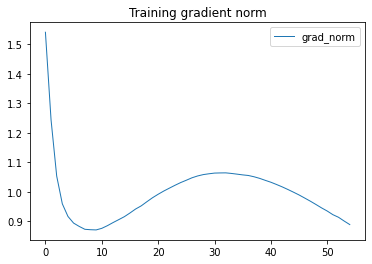

In [13]:
%%time
# CNN 3 (increase kernel size)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=6, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn3',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 0.9818
Train accuracy 0.994
Test accuracy 0.982
CPU times: user 4min 25s, sys: 59.9 s, total: 5min 25s
Wall time: 3min 38s


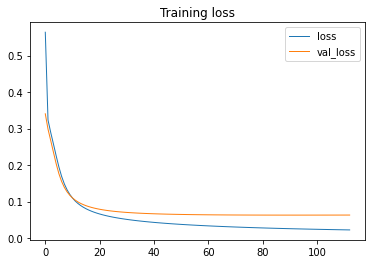

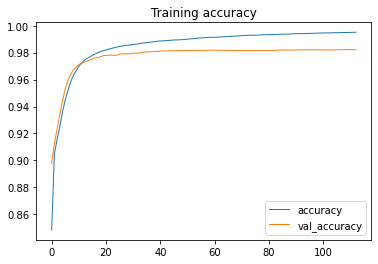

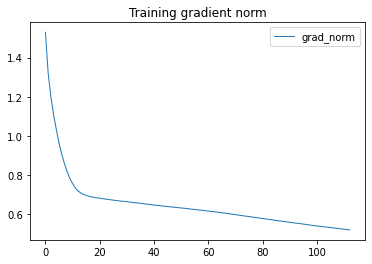

In [14]:
%%time
# CNN 4 (add a pooling layer)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn4',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0603 - accuracy: 0.9824
Train accuracy 0.992
Test accuracy 0.982
CPU times: user 8min 46s, sys: 1min 49s, total: 10min 36s
Wall time: 7min 32s


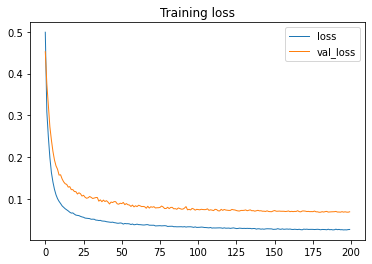

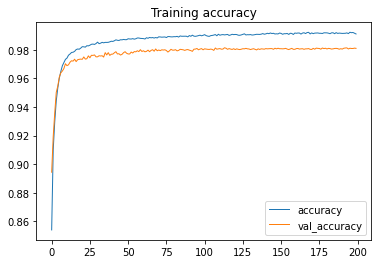

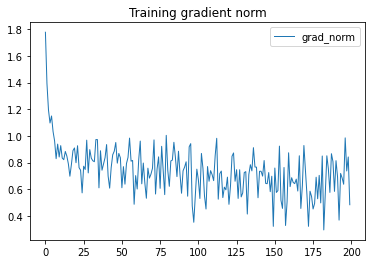

In [15]:
%%time
# CNN 5 (add a dropout layer)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn5',
)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
79/79 [==============================] - 0s 1ms/step - loss: 0.0788 - accuracy: 0.9775
Train accuracy 0.987
Test accuracy 0.978
CPU times: user 1min 26s, sys: 23.9 s, total: 1min 50s
Wall time: 1min 14s


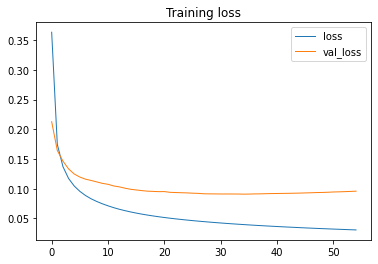

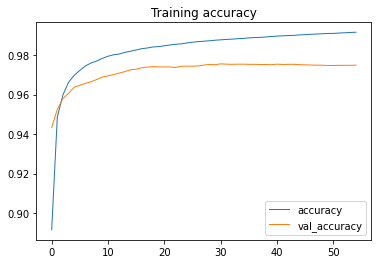

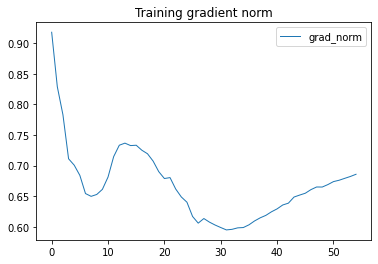

In [7]:
%%time
# CNN 6 (add a batch normalization layer)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn6',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9933
Train accuracy 0.998
Test accuracy 0.993
CPU times: user 2min 55s, sys: 18.6 s, total: 3min 14s
Wall time: 2min 31s


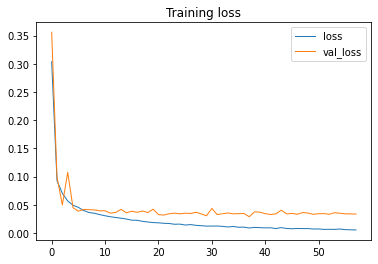

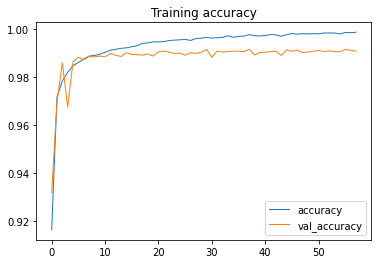

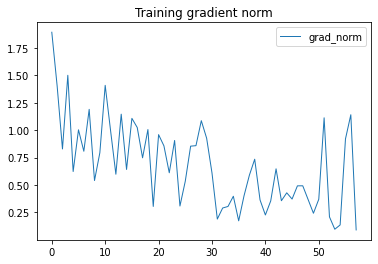

In [13]:
%%time
# CNN 7 (more layers)
model = KerasSequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05), # rotate between -2*pi*0.05..2*pi*0.05
    tf.keras.layers.ZeroPadding2D(2),  # 28 + 2*2 = 32
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn7',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9938
Train accuracy 0.998
Test accuracy 0.994
CPU times: user 2min 39s, sys: 19.2 s, total: 2min 59s
Wall time: 2min 5s


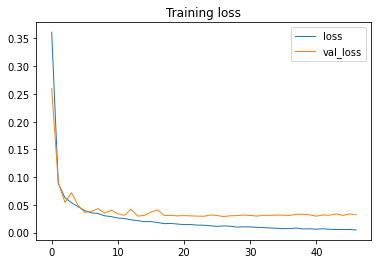

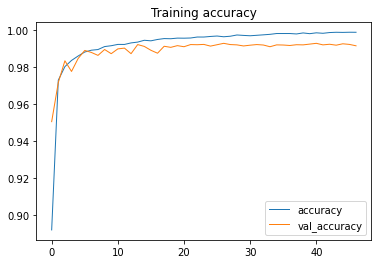

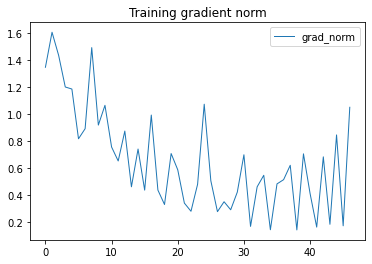

In [20]:
%%time
# CNN 8 (more layers, v.2)
model = KerasSequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05), # rotate between -2*pi*0.05..2*pi*0.05
    tf.keras.layers.ZeroPadding2D(2),  # 28 + 2*2 = 32
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, kernel_initializer=tf.keras.initializers.constant(0)),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn8',
)

#### CNN + Deconvolution (U-Net)
- https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py
- https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
- https://arxiv.org/abs/1505.04597

In [ ]:
%%time
# U-NET
# TODO: Finish
model = KerasSequential([
    # --- Preprocess
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05), # rotate between -2*pi*0.05..2*pi*0.05
    tf.keras.layers.ZeroPadding2D(2),  # 28 + 2*2 = 32
    # --- Downsample
    tf.keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    # --- Upsample
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding='same')
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=2, strides=2, padding='same')
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # --- Output
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=2, padding='same')
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_unet',
)

### PyTorch

In [75]:
class PrepareData(Dataset):
    def __init__(self, X, y, transform=None, device=None):
        self.X = torch.from_numpy(X[:, np.newaxis, :, :]).float()
#         self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X, y = self.X[idx], self.y[idx]
        if self.transform is not None:
            X = self.transform(X)
        if self.device is not None:
            X, y = X.to(self.device), y.to(self.device)
        return X, y
    
    def to(self, device):
        self.device = device
#         self.X = self.X.to(device)
#         self.y = self.y.to(device)
    

ds_train = PrepareData(
    x_train / 255., y_train, 
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.RandomRotation(.05 * 360.),  # rotate between -2*pi*0.05..2*pi*0.05)
        torchvision.transforms.ToTensor(),
    ]),
)
ds_train = PrepareData(x_train / 255., y_train)
ds_test = PrepareData(x_test / 255., y_test)

In [73]:
class TorchLimitedScheduler:
    def __init__(self, scheduler, first_epoch=0, last_epoch=1000):
        self.scheduler = scheduler
        self.first_epoch = first_epoch
        self.last_epoch = last_epoch
        self.current_epoch = 0

    def step(self):
        if (self.current_epoch >= self.first_epoch) and (self.current_epoch < self.last_epoch):
            self.scheduler.step()
        self.current_epoch += 1

def eval_loss_nograd(model, loss_func, loader):
    with torch.no_grad():
        loss_c = 0
        for X_batch, y_batch in loader:
            loss = loss_func(model(X_batch), y_batch)
            loss_c += loss.item()
        return loss_c / len(loader) 
    
def torch_accuracy_score(predicted, labels):
    predicted = torch.argmax(predicted.data, 1)
    n_correct = (predicted == labels).sum() / float(len(predicted))
    return n_correct

def torch_mae(predicted, labels):
    return (predicted - labels).abs().sum() / float(len(predicted))

torch_metrics = {
    'accuracy': torch_accuracy_score,
    'mae': torch_mae,
}

def train_eval_model(model, optimizer, loss_func, train_ds, test_ds, scheduler=None, early_stopping=None,
                     device_name='auto', metrics=tuple(), board_prefix=None,
                     n_epoch=1000, n_batch=128):
    if device_name == 'auto':
        device_name = 'cuda' if torch.cuda.is_available() else 'gpu'
    device = torch.device(device_name)
    model.to(device)
    train_ds.to(device)
    test_ds.to(device)
    print(f'Running on {device_name}...')

    train_size = int(len(train_ds)*0.8)
    train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, len(train_ds)-train_size])
    train_loader = DataLoader(train_ds, batch_size=n_batch, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=n_batch, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=n_batch, shuffle=True)
    
    if board_prefix is not None:
        board_name = board_prefix + '_' + dt.datetime.now().strftime('%Y%m%dT%H%M%S')
        writer = SummaryWriter(log_dir=Path('logs/torch/') / board_name)
    else:
        writer = None
 
    train_history = defaultdict(list)
    min_val_loss = None
    steps_without_improvement = 0
    for epoch in range(n_epoch):
        loss_c = 0
        grad_norm_c = 0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(X_train_batch), y_train_batch)
            loss.backward()
            optimizer.step()
            loss_c += loss.item()
            for p in islice(model.parameters(), 5):
                grad_norm_c += float(torch.norm(p.grad))
        train_history['loss'].append(loss_c/len(train_loader))
        train_history['grad_norm'].append(grad_norm_c/len(train_loader))

        train_history['val_loss'].append(eval_loss_nograd(model, loss_func, val_loader))
        for metric in metrics:
            train_history[metric].append(eval_loss_nograd(model, torch_metrics[metric], train_loader))
            train_history[f'val_{metric}'].append(eval_loss_nograd(model, torch_metrics[metric], val_loader))
            
        if early_stopping is not None:
            if (min_val_loss is None) or (train_history['val_loss'][-1] < min_val_loss):
                min_val_loss = train_history['val_loss'][-1]
                best_state = copy.deepcopy(model.state_dict())
                steps_without_improvement = 0
            else:
                steps_without_improvement += 1
                if steps_without_improvement >= early_stopping:
                    model.load_state_dict(best_state)
                    break
        
        if writer is not None:
            for k, v in train_history.items():
                k_ = f'{k[4:]}/val' if k.startswith('val_') else f'{k}/train'
                writer.add_scalar(k_, v[-1], epoch)
                    
        if scheduler is not None:
            scheduler.step()

    _ = pd.DataFrame(train_history)[['loss', 'val_loss']].plot(title='Training loss', lw=1, alpha=0.8)

    for metric in metrics:
        _ = pd.DataFrame(train_history)[[metric, f'val_{metric}']].plot(title=f'Training {metric}', lw=1, alpha=0.8)
        train_metric = eval_loss_nograd(model, torch_metrics[metric], train_loader)
        test_metric = eval_loss_nograd(model, torch_metrics[metric], test_loader)
        print(f'Train {metric} {train_metric:.3f}')
        print(f'Test {metric}  {test_metric:.3f}')
    
    _ = pd.DataFrame(train_history)[['grad_norm']].plot(title='Training gradient norm', lw=1, alpha=0.8)

#### Feedforward

Running on cuda...
Train accuracy 0.997
Test accuracy  0.976
CPU times: user 4min 48s, sys: 1.61 s, total: 4min 50s
Wall time: 4min 20s


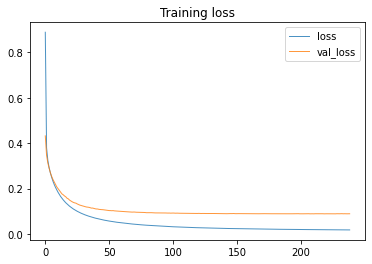

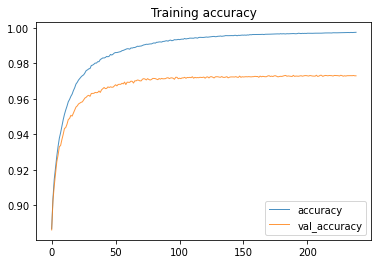

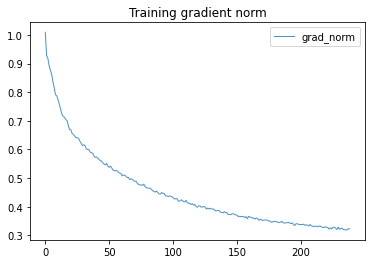

In [48]:
%%time
# Feedforward
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
scheduler = TorchLimitedScheduler(
    torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99),
    first_epoch=10, last_epoch=200,
)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(
    model, optimizer, loss_func, ds_train, ds_test, scheduler=scheduler, early_stopping=20,
    metrics=['accuracy'],
    board_prefix='mnist_mlp',
)

#### CNN

Running on cuda...
Train accuracy 0.999
Test accuracy  0.992
CPU times: user 3min 31s, sys: 237 ms, total: 3min 32s
Wall time: 3min 28s


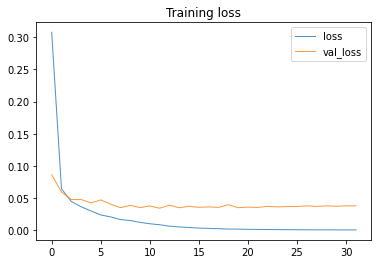

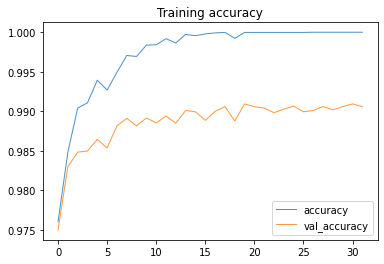

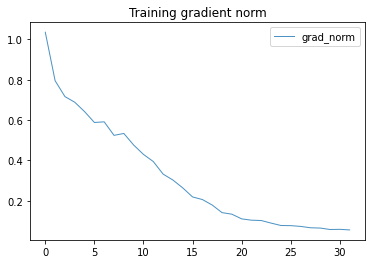

In [76]:
%%time
# CNN 7
model = torch.nn.Sequential(
#     torchvision.transforms.RandomRotation(.05 * 360.),  # moved to the dataset class
    torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
scheduler = TorchLimitedScheduler(
    torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99),
    first_epoch=10, last_epoch=200,
)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(
    model, optimizer, loss_func, ds_train, ds_test, scheduler=scheduler, early_stopping=20,
    metrics=['accuracy'],
    board_prefix='mnist_cnn7',
)

## Correlated Time Series

Loading data: ss_ext.pickle...



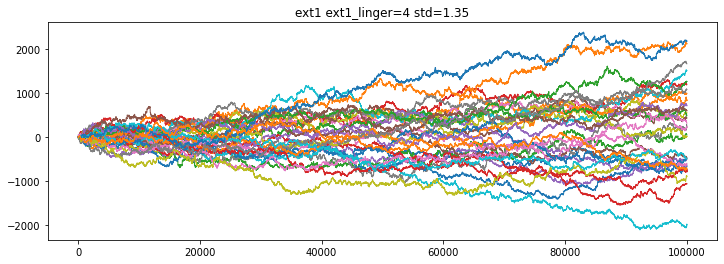

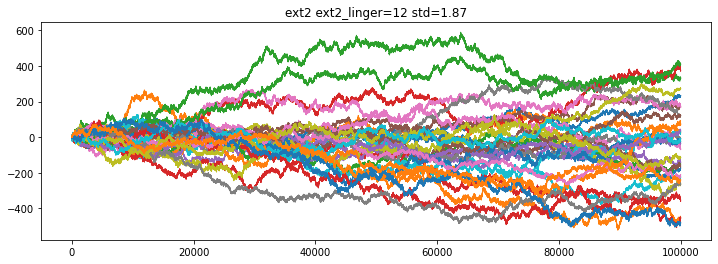

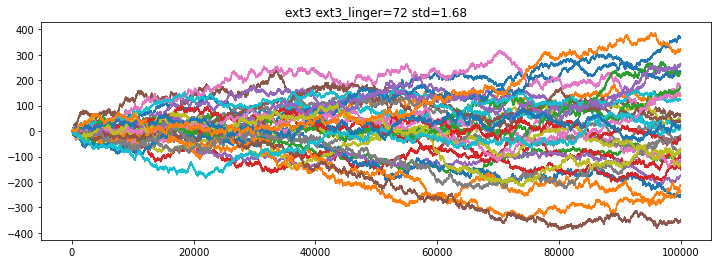

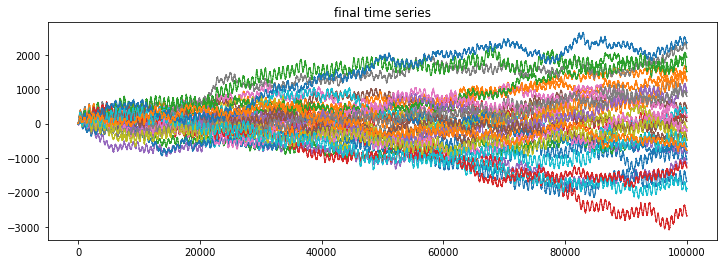

In [5]:
def np_rolling(a, window, np_fun, axis=-1):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return np_fun(rolling, axis=axis)

def np_rolling_padded(a, window, np_fun, axis=-1):
    a = np_rolling(a[:-1], window, np_fun, axis=axis)
    return np.concatenate((np.zeros(window), a), axis=axis)

def weighted_mean(a, weight_fun, axis=-1):
    w = weight_fun(np.arange(a.shape[axis]))
    w /= np.sum(w)
    dims = np.ones(len(a.shape), dtype=int)
    dims[axis] = -1
    w = w.reshape(dims)
    return np.sum(a * w, axis=axis)

def corr(x, y):
    return np.corrcoef(x, y)[0, 1].round(3)

def _min_max_foo(ext, ext_linger):
    ext_max = np.empty_like(ext)
    ext_min = np.empty_like(ext)
    ext_mean = np.empty_like(ext)
    p = ext.shape[1]
    for i in range(p):
        ext_max[:, i] = np_rolling_padded(ext[:, i], ext_linger, np.max)
        ext_min[:, i] = np_rolling_padded(ext[:, i], ext_linger, np.min)
        ext_mean[:, i] = np_rolling_padded(ext[:, i], ext_linger, np.mean)
    ext_all = (ext_max + ext_min)
    ext_all = 0.2 * np.sign(ext_all) * (np.abs(ext_all) ** 2) * np.random.uniform(0.8, 1.2, p)
#     ext_all = (ext_max - ext_min) * np.sign(ext_mean) * np.random.uniform(0.8, 1.2, p)
    return ext_all

def _sin_mean_foo(ext, ext_linger):
    ext_mean = np.empty_like(ext)
    p = ext.shape[1]
    for i in range(p):
        ext_mean[:, i] = np_rolling_padded(
            ext[:, i], ext_linger, lambda x, axis: weighted_mean(x, np.sin, axis=axis)
        )
    ext_all = 1.5 * np.arctan(ext_mean) * np.random.uniform(0.8, 1.2, p)
    return ext_all

def generate_time_series_data(n, p, filename, override_cache=False, show_summary=True):
    stddev = 1.
    auto_corr = 0.3
    cross_corr = 0.3
    season_period = 24 * 30
    season_impact = 1.
    ext1_impact = 1.
    ext1_linger = 4    # short-term impact
    ext2_impact = 1.
    ext2_linger = 12    # mid-term impact
    ext3_impact = 1.
    ext3_linger = 24*3  # long-term impact
    cache_path = Path('temp') / filename
    
    cache_path.parent.mkdir(parents=True, exist_ok=True)    
    if not override_cache and cache_path.exists():
        print(f'Loading data: {filename}...')
        ext1, ext2, ext3, ss = cloudpickle.load(open(cache_path, 'rb'))
        ext1_all = _min_max_foo(ext1, ext1_linger)#.cumsum(axis=0)
        ext2_all = _sin_mean_foo(ext2, ext2_linger)#.cumsum(axis=0)
        ext3_all = _sin_mean_foo(ext3, ext3_linger)#.cumsum(axis=0)
    else:
        print(f'Generating data: {filename}...')
        noise_jumps = np.random.normal(0, stddev, size=(n, p))
        print(corr(noise_jumps[:, 0], noise_jumps[:, 1]), corr(noise_jumps[0, :], noise_jumps[1, :]))

        noise_jumps = noise_jumps + auto_corr/(1-auto_corr)*np.roll(noise_jumps, 1, axis=0)
        print(corr(noise_jumps[:, 0], noise_jumps[:, 1]), corr(noise_jumps[0, :], noise_jumps[1, :]))

        cross_corr_matrix = np.eye(p) + np.eye(p, k=-1) * cross_corr
        noise_jumps = noise_jumps @ cross_corr_matrix
        print(corr(noise_jumps[:, 0], noise_jumps[:, 1]), corr(noise_jumps[0, :], noise_jumps[1, :]))

        ext1 = np.random.laplace(0.0, 1., size=(n, p))#.cumsum(axis=0)
        ext1_all = _min_max_foo(ext1, ext1_linger)#.cumsum(axis=0)

        ext2 = np.random.normal(0., 1., size=(n, p))#.cumsum(axis=0)
        ext2_all = _sin_mean_foo(ext2, ext2_linger)#.cumsum(axis=0)
        
        ext3 = np.random.normal(0., 1., size=(n, p))#.cumsum(axis=0)
        ext3_all = _sin_mean_foo(ext3, ext3_linger)#.cumsum(axis=0)

        seasons = (np.sin(2*np.pi*np.linspace(0, n // season_period, num=n)))
        # seasons = (np.sin(2*np.pi*np.linspace(0, n // season_period, num=n)))
        seasons = np.outer(seasons, np.random.uniform(0.6, 1.4, p))#.cumsum(axis=0)

        ss = ext1_impact*ext1_all + ext2_impact*ext2_all + ext3_impact*ext3_all + season_impact*seasons + noise_jumps
#         ss = 0*ext1_all + ext2_impact*ext2_all + season_impact*seasons + noise_jumps
        ss = ss.cumsum(axis=0)

        cloudpickle.dump([ext1, ext2, ext3, ss], open(cache_path, 'wb'))
        
        if show_summary:
            pd.DataFrame(noise_jumps.cumsum(axis=0)).plot(lw=1, figsize=(12,4), legend=False, title='noise')
            pd.DataFrame(seasons.cumsum(axis=0)).plot(lw=1, figsize=(12,4), legend=False, title=f'seasons {season_period=}')
    
    if show_summary:
        print()
        pd.DataFrame(ext1_all.cumsum(axis=0)).plot(
            lw=1, figsize=(12,4), legend=False,
            title=f'ext1 {ext1_linger=} std={np.std(ext1_impact*ext1_all):.2f}'
        )
        pd.DataFrame(ext2_all.cumsum(axis=0)).plot(
            lw=1, figsize=(12,4), legend=False, 
            title=f'ext2 {ext2_linger=} std={np.std(ext2_impact*ext2_all):.2f}'
        )
        pd.DataFrame(ext3_all.cumsum(axis=0)).plot(
            lw=1, figsize=(12,4), legend=False, 
            title=f'ext3 {ext3_linger=} std={np.std(ext3_impact*ext3_all):.2f}'
        )
        pd.DataFrame(ss).plot(lw=1, figsize=(12,4), legend=False, title='final time series')

    return ext1, ext2, ext3, ss

ext1_ext, ext2_ext, ext3_ext, ss_ext = generate_time_series_data(
    n=100000, p=32, filename='ss_ext.pickle', show_summary=True, override_cache=False
)
ext1, ext2, ext3, ss = ext1_ext[:10000], ext2_ext[:10000], ext3_ext[:10000], ss_ext[:10000]

_=_

In [8]:
print(ss.shape)
print(ext1.shape)
print(ext2.shape)
print(ext3.shape)

(10000, 32)
(10000, 32)
(10000, 32)
(10000, 32)


-- Top frequencies --
    period_ratio  period_points      amplitude
13      0.066667     666.666667  753569.062500
2       0.250000    2500.000000  454816.843750
12      0.071429     714.285714  229096.265625
1       0.333333    3333.333333  203938.640625
3       0.200000    2000.000000  149968.812500


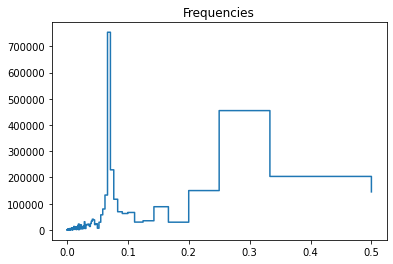

In [7]:
# fft = tf.signal.rfft(np.sin(2*np.pi*np.linspace(0, 20, 20*100)+0.6))
# fft = tf.signal.rfft((np.cumsum(seasons[:, 0])))
fft = tf.signal.rfft(((ss[:, 0])))
fft = fft[1:]  # Discard the wave for frequency == 1
plt.step(1. / np.arange(2, len(fft)+2), np.abs(fft))  # The true frequency is 24*30 = 720
plt.title('Frequencies')

df = pd.DataFrame({
    'period_ratio': 1./np.arange(2, len(fft)+2),  # period = 1 / frequency
    'period_points': 1./np.arange(2, len(fft)+2)*len(fft)*2,  # RFFT only returns the first half of frequencies 
    'amplitude': np.abs(fft),
}).sort_values('amplitude', ascending=False)
print('-- Top frequencies --')
print(df.head(5))  

### TF2
- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://www.tensorflow.org/guide/keras/rnn
- https://www.tensorflow.org/guide/data
- https://training.dewesoft.com/online/course/fft-spectral-analysis
- https://en.wikipedia.org/wiki/Fourier_transform

In [6]:
def _tf_new_train_step(self, data):
    X, y = data
    with tf.GradientTape() as tape:
        y_pred = self(X, training=True)
        loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    metric_dict = {m.name: m.result() for m in self.metrics}
    grad_norm = tf.linalg.global_norm(gradients)
    metric_dict.update({'grad_norm': grad_norm})
    return metric_dict

class KerasModel(tf.keras.Model):
    def train_step(self, data):
        return _tf_new_train_step(self, data)

class KerasModelDelta(KerasModel):
    def call(self, inputs, *args, **kwargs):
        delta = super().call(inputs, *args, **kwargs)
        # (batch, sample, series, feature)
        if ((len(delta.shape) != len(inputs.shape)) or
            (delta.shape[0] != inputs.shape[0]) or
            (delta.shape[2] != inputs.shape[2])):
            raise AssertionError(f'{inputs.shape=} is incompatible with {delta.shape}')
        return inputs[:, -delta.shape[1]:, :, :1] + delta
    
class KerasSequential(tf.keras.Sequential):
    def train_step(self, data):
        return _tf_new_train_step(self, data)
    
class KerasSequentialDelta(KerasSequential):
    def call(self, inputs, *args, **kwargs):
        delta = super().call(inputs, *args, **kwargs)
        # (batch, sample, series, feature)
        if ((len(delta.shape) != len(inputs.shape)) or
            (delta.shape[0] != inputs.shape[0]) or
            (delta.shape[2] != inputs.shape[2])):
            raise AssertionError(f'{inputs.shape=} is incompatible with {delta.shape}')
        return inputs[:, -delta.shape[1]:, :, :1] + delta
    
tf_zero_init_kwargs = dict(
    kernel_initializer=tf.initializers.zeros(), 
    bias_initializer=tf.initializers.zeros(),
)

def train_eval_model(model, optimizer, loss, train_ds, val_ds, test_ds, metrics=tuple(), grad_norm=True,
                     n_epoch=400,
                     callbacks=None, board_prefix=None, device_name=None,
                     history_skip_n_first=5):
    with tf.device(device_name):
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

        if board_prefix is not None:
            board_name = board_prefix + '_' + dt.datetime.now().strftime('%Y%m%dT%H%M%S')
            callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=Path('logs/tf2/') / board_name, update_freq='epoch'))
        train_history = model.fit(
            train_ds,
            epochs=n_epoch, 
            validation_data=val_ds,
            verbose=0,
            callbacks=callbacks,
        )

        _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].iloc[history_skip_n_first:].plot(title='Training loss', lw=1)
        for metric in metrics:
            _ = pd.DataFrame(train_history.history)[[metric, f'val_{metric}']].iloc[history_skip_n_first:].plot(title=f'Training {metric}', lw=1)
        if grad_norm:
            _ = pd.DataFrame(train_history.history)[['grad_norm']].iloc[history_skip_n_first:].plot(title=f'Training gradient norm', lw=1)

        train_results = model.evaluate(train_ds)
        test_results = model.evaluate(test_ds)
        for i, metric in enumerate(metrics):
            print(f'Train {metric} {train_results[i+1]:.4f}')
            print(f'Test  {metric} {test_results[i+1]:.4f}')
            
def plot_predictions(model, ds, ts_num=0, first_idx=0, last_idx=-1, figsize=(12,5)):
    if plot_predictions is not None:
        y_real, y_hat = [], []
        for x, y in test_ds:
            y_real.append(np.ravel(y.numpy()[:, :, ts_num, 0]))
            y_hat.append(np.ravel(model(x, training=False)[:, :, ts_num, 0]))
        y_real, y_hat = np.concatenate(y_real), np.concatenate(y_hat)
        e = np.abs(y_real - y_hat)
        mae = np.mean(e)
        cvar95 = np.mean(np.sort(e)[int(len(e)*0.95):])
        pd.DataFrame({
            'y_real': y_real[first_idx:last_idx],
            'y_hat': y_hat[first_idx:last_idx],
        }).plot(figsize=figsize, lw=1, title=f'Predictions {ts_num}: {mae=:.4f} {cvar95=:.4f}')
            
def get_lr_scheduler(decay_rate, first_epoch=0, last_epoch=1000):
    def sheduler_fun(epoch, lr):
        if (epoch > first_epoch) and (epoch < last_epoch):
            return lr * decay_rate
        else:
            return lr
    return sheduler_fun

def make_ts_datasets_old(labels, features_list, val_ratio, test_ratio, feature_window, label_window, label_offset, 
                         normalize=True, shuffle_train=True, shuffle_val=True, batch_size=512):
    assert feature_window >= 1
    assert label_offset >= 0
    assert label_window >= 1
    assert len(labels.shape) == 2
    if features_list is not None:
        for features in features_list:
            assert features.shape == labels.shape
        
    # Shape lables and features
    labels_ = labels[feature_window+label_offset:]
    if features_list is not None:
        features_ = np.stack([labels] + features_list, axis=-1)[:-(label_window+label_offset)]
    else:
        features_ = labels[:-(label_window+label_offset)]
    n = len(labels_)
    
    # Normalize
    if normalize:
        features_mean = np.mean(features_[: int(n*(1-val_ratio-test_ratio))], axis=0)
        features_std = np.std(features_[: int(n*(1-val_ratio-test_ratio))], axis=0)
        features_ = (features_ - features_mean) / features_std
    
    # Create datasets
    # TODO: replace generators with TF native methods for scalability
    def train_gen():
        perm = np.random.permutation if shuffle_train else lambda x: x
        for i in perm(range(0, int(n*(1-val_ratio-test_ratio)))):
            yield features_[i:i+feature_window], labels_[i:i+label_window]
            
    def val_gen():
        perm = np.random.permutation if shuffle_val else lambda x: x
        for i in perm(range(int(n*(1-val_ratio-test_ratio)), int(n*(1-test_ratio)))):
            yield features_[i:i+feature_window], labels_[i:i+label_window]
            
    def test_gen():
        for i in range(int(n*(1-test_ratio)), n):
            yield features_[i:i+feature_window], labels_[i:i+label_window]
    
    output_dtypes = (tf.float32, tf.float32)
    output_shapes = features_[:feature_window].shape, labels_[:label_window].shape
    train_ds = tf.data.Dataset.from_generator(train_gen, output_dtypes, output_shapes)
    val_ds = tf.data.Dataset.from_generator(val_gen, output_dtypes, output_shapes)
    test_ds = tf.data.Dataset.from_generator(test_gen, output_dtypes, output_shapes)
    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    test_ds = test_ds.batch(batch_size)
    return train_ds, val_ds, test_ds

def make_ts_datasets(labels, features_list, val_ratio, test_ratio, feature_window, label_window, label_offset, 
                     normalize=True, shuffle_train=True, shuffle_val=True, 
                     batch_size=128, drop_remainder=False):
    assert feature_window >= 1
    assert label_window >= 1
    assert len(labels.shape) == 2
    if features_list is not None:
        for features in features_list:
            assert features.shape == labels.shape
        
    # Shape lables and features
    if features_list is not None:
        table = np.stack([labels] + features_list, axis=-1)
    else:
        table = labels[..., np.newaxis]
    table = table.astype(np.float32)
    
    # Split data on train, val and test
    part_window = feature_window + label_offset
    full_window = feature_window + label_offset + label_window 
    n = len(table) - part_window
    train_table = table[:part_window + int(n*(1-val_ratio-test_ratio))]
    val_table = table[int(n*(1-val_ratio-test_ratio)):part_window + int(n*(1-test_ratio))]
    test_table = table[int(n*(1-test_ratio)):]
    
    # Normalize
    if normalize:
        table_mean = np.mean(train_table, axis=0)
        table_std = np.std(train_table, axis=0)
        train_table = (train_table - table_mean) / table_std
        val_table = (val_table - table_mean) / table_std
        test_table = (test_table - table_mean) / table_std
    
    # Create datasets
    def _split_window(table):
        # the first value is batch, which is set to 1
        inputs = table[0, :feature_window, :, :]
        labels = table[0, feature_window + label_offset:, :, 0][..., tf.newaxis]
        return inputs, labels
    
    def _create_ds(table, shuffle):
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=table,
            targets=None,
            sequence_length=full_window,
            sampling_rate=1,
            sequence_stride=label_window,
            shuffle=False,
            batch_size=1,
        )
        ds = ds.map(_split_window)
        ds = ds.batch(batch_size, drop_remainder=drop_remainder)
        if shuffle:
            ds = ds.shuffle(len(ds))
        return ds
    
    train_ds = _create_ds(train_table, shuffle_train)
    val_ds = _create_ds(val_table, shuffle_val)
    test_ds = _create_ds(test_table, False)
    return train_ds, val_ds, test_ds

In [10]:
# --- Test run without features
train_ds, val_ds, test_ds = make_ts_datasets(
    labels=np.arange(0, 12)[:, np.newaxis], 
    features_list=None,  
    val_ratio=0.3, test_ratio=0.3, 
    feature_window=2, label_window=1, label_offset=0, 
    normalize=False, shuffle_train=True, shuffle_val=True,
    batch_size=3, drop_remainder=False,
)

for x, y in train_ds:
    print(f'{x=}\n{y=}\n.')
print('--------------------')
for x, y in val_ds:
    print(f'{x=}\n{y=}\n.')
print('--------------------')
for x, y in test_ds:
    print(f'{x=}\n{y=}\n.')

x=<tf.Tensor: shape=(3, 2, 1, 1), dtype=float32, numpy=
array([[[[0.]],

        [[1.]]],


       [[[1.]],

        [[2.]]],


       [[[2.]],

        [[3.]]]], dtype=float32)>
y=<tf.Tensor: shape=(3, 1, 1, 1), dtype=float32, numpy=
array([[[[2.]]],


       [[[3.]]],


       [[[4.]]]], dtype=float32)>
.
--------------------
x=<tf.Tensor: shape=(1, 2, 1, 1), dtype=float32, numpy=
array([[[[6.]],

        [[7.]]]], dtype=float32)>
y=<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[8.]]]], dtype=float32)>
.
x=<tf.Tensor: shape=(3, 2, 1, 1), dtype=float32, numpy=
array([[[[3.]],

        [[4.]]],


       [[[4.]],

        [[5.]]],


       [[[5.]],

        [[6.]]]], dtype=float32)>
y=<tf.Tensor: shape=(3, 1, 1, 1), dtype=float32, numpy=
array([[[[5.]]],


       [[[6.]]],


       [[[7.]]]], dtype=float32)>
.
--------------------
x=<tf.Tensor: shape=(3, 2, 1, 1), dtype=float32, numpy=
array([[[[ 7.]],

        [[ 8.]]],


       [[[ 8.]],

        [[ 9.]]],


       [[[

In [10]:
# --- Test run without features (label_window=2)
train_ds, val_ds, test_ds = make_ts_datasets(
    labels=np.arange(0, 20)[:, np.newaxis], 
    features_list=None,  
    val_ratio=0.3, test_ratio=0.3, 
    feature_window=2, label_window=2, label_offset=-1, 
    normalize=False, shuffle_train=False, shuffle_val=False,
    batch_size=128,
)

for x, y in train_ds:
    print(f'{x=}\n{y=}')
print('--------------------')
for x, y in val_ds:
    print(f'{x=}\n{y=}')
print('--------------------')
for x, y in test_ds:
    print(f'{x=}\n{y=}')

x=<tf.Tensor: shape=(3, 2, 1, 1), dtype=float32, numpy=
array([[[[0.]],

        [[1.]]],


       [[[2.]],

        [[3.]]],


       [[[4.]],

        [[5.]]]], dtype=float32)>
y=<tf.Tensor: shape=(3, 2, 1, 1), dtype=float32, numpy=
array([[[[1.]],

        [[2.]]],


       [[[3.]],

        [[4.]]],


       [[[5.]],

        [[6.]]]], dtype=float32)>
--------------------
x=<tf.Tensor: shape=(3, 2, 1, 1), dtype=float32, numpy=
array([[[[ 7.]],

        [[ 8.]]],


       [[[ 9.]],

        [[10.]]],


       [[[11.]],

        [[12.]]]], dtype=float32)>
y=<tf.Tensor: shape=(3, 2, 1, 1), dtype=float32, numpy=
array([[[[ 8.]],

        [[ 9.]]],


       [[[10.]],

        [[11.]]],


       [[[12.]],

        [[13.]]]], dtype=float32)>
--------------------
x=<tf.Tensor: shape=(3, 2, 1, 1), dtype=float32, numpy=
array([[[[13.]],

        [[14.]]],


       [[[15.]],

        [[16.]]],


       [[[17.]],

        [[18.]]]], dtype=float32)>
y=<tf.Tensor: shape=(3, 2, 1, 1), dtype=float

In [11]:
# --- Test run with features
train_ds, val_ds, test_ds = make_ts_datasets(
    labels=np.arange(0, 10)[:, np.newaxis], 
    features_list=[np.arange(0, -10, -1)[:, np.newaxis], np.arange(-10, -20, -1)[:, np.newaxis]],  
    val_ratio=0.3, test_ratio=0.3, 
    feature_window=2, label_window=1, label_offset=0, 
    normalize=False, shuffle_train=False, shuffle_val=False,
    batch_size=2,
)

print(len(train_ds))
for x, y in train_ds:
    print(f'{x=}\n{y=}')
print('--------------------')
print(len(val_ds))
for x, y in val_ds:
    print(f'{x=}\n{y=}')
print('--------------------')
print(len(test_ds))
for x, y in test_ds:
    print(f'{x=}\n{y=}')

2
x=<tf.Tensor: shape=(2, 2, 1, 3), dtype=float32, numpy=
array([[[[  0.,   0., -10.]],

        [[  1.,  -1., -11.]]],


       [[[  1.,  -1., -11.]],

        [[  2.,  -2., -12.]]]], dtype=float32)>
y=<tf.Tensor: shape=(2, 1, 1, 1), dtype=float32, numpy=
array([[[[2.]]],


       [[[3.]]]], dtype=float32)>
x=<tf.Tensor: shape=(1, 2, 1, 3), dtype=float32, numpy=
array([[[[  2.,  -2., -12.]],

        [[  3.,  -3., -13.]]]], dtype=float32)>
y=<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[4.]]]], dtype=float32)>
--------------------
1
x=<tf.Tensor: shape=(2, 2, 1, 3), dtype=float32, numpy=
array([[[[  3.,  -3., -13.]],

        [[  4.,  -4., -14.]]],


       [[[  4.,  -4., -14.]],

        [[  5.,  -5., -15.]]]], dtype=float32)>
y=<tf.Tensor: shape=(2, 1, 1, 1), dtype=float32, numpy=
array([[[[5.]]],


       [[[6.]]]], dtype=float32)>
--------------------
2
x=<tf.Tensor: shape=(2, 2, 1, 3), dtype=float32, numpy=
array([[[[  5.,  -5., -15.]],

        [[  6.,  -6., -16

#### Baseline: last value

In [12]:
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=1, label_window=1, label_offset=0, 
#     normalize=False,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)

class Baseline(tf.keras.Model):
    def call(self, inputs):
        return inputs
    
baseline = Baseline()
baseline.compile(loss=tf.losses.MSE, metrics=['mae'])
baseline.evaluate(train_ds)
_ , benchmart_mae = baseline.evaluate(test_ds)
_=_
print(f'\nLast value MAE (test) = {benchmart_mae:.4f}')

(128, 1, 1, 1) (128, 1, 1, 1)
16/16 [==============================] - 0s 3ms/step - loss: 4.4494e-04 - mae: 0.0164

Last value MAE (test) = 0.0164


#### Baseline: Linear Regression

In [13]:
# LR without external features

def ds_to_numpy(ds):
    X, y = [], []
    for x_, y_ in train_ds:
        X.append(x_)
        y.append(y_)
    X, y = np.concatenate(X, axis=0), np.concatenate(y, axis=0)
    print(X.shape, y.shape)
    return np.reshape(X, (-1, X.shape[1])), np.reshape(y, (-1,))

train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0, 
)

x_train, y_train = ds_to_numpy(train_ds)
x_test, y_test = ds_to_numpy(test_ds)

m = LinearRegression()
m.fit(x_train, y_train)
y_hat_train = m.predict(x_train)
y_hat_test = m.predict(x_test)

print(f'\nLR MAE (train) = {mean_absolute_error(y_train, y_hat_train):.4f}')
print(f'\nLR MAE (test) = {mean_absolute_error(y_test, y_hat_test):.4f}')


(5998, 2, 1, 1) (5998, 1, 1, 1)
(5998, 2, 1, 1) (5998, 1, 1, 1)

LR MAE (train) = 0.0130

LR MAE (test) = 0.0130


In [14]:
# LR with external features

def _make_features(x_):
    x_new = np.vstack([
        x_[:, -1, 0, 0],
        x_[:, -2, 0, 0],
        x_[:, -1, 0, 1],
        np.mean(x_[:, -4:, 0, 1], axis=1),
        np.max(x_[:, -4:, 0, 1], axis=1),
        np.min(x_[:, -4:, 0, 1], axis=1),
        x_[:, -1, 0, 2],
        x_[:, -2, 0, 2],
        x_[:, -3, 0, 2],
        x_[:, -4, 0, 2],
#         np.max(x_[:, -12:, 0, 2], axis=1),
#         np.min(x_[:, -12:, 0, 2], axis=1),
        x_[:, -1, 0, 3],
        x_[:, -2, 0, 3],
        x_[:, -3, 0, 3],
        x_[:, -4, 0, 3],
        x_[:, -5, 0, 3],
        x_[:, -6, 0, 3],
        x_[:, -7, 0, 3],
        x_[:, -8, 0, 3],
#         np.max(x_[:, :, 0, 3], axis=1),
#         np.min(x_[:, :, 0, 3], axis=1),
    ]).T
    return x_new

def ds_to_numpy(ds):
    X, y = [], []
    for x_, y_ in train_ds:
        X.append(_make_features(x_))
        y.append(y_)
    X, y = np.concatenate(X, axis=0), np.concatenate(y, axis=0)
    print(X.shape, y.shape)
    return np.reshape(X, (-1, X.shape[1])), np.reshape(y, (-1,))


train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], [ext1[:, [0]], ext2[:, [0]], ext3[:, [0]]], val_ratio=0.2, test_ratio=0.2, 
    feature_window=24*3, label_window=1, label_offset=0, 
)

x_train, y_train = ds_to_numpy(train_ds)
x_test, y_test = ds_to_numpy(test_ds)

# m = LGBMRegressor(n_estimators=100, learning_rate=0.05)
m = LinearRegression()
m.fit(x_train, y_train)
y_hat_train = m.predict(x_train)
y_hat_test = m.predict(x_test)

print(f'\nLR MAE (train) = {mean_absolute_error(y_train, y_hat_train):.4f}')
print(f'\nLR MAE (test) = {mean_absolute_error(y_test, y_hat_test):.4f}')

(5956, 18) (5956, 1, 1, 1)
(5956, 18) (5956, 1, 1, 1)

LR MAE (train) = 0.0112

LR MAE (test) = 0.0112


#### Baseline: GB

In [15]:
# TO DO

#### Linear

- Optimization is not stable - possibly due to delta dependencies
- Predicting deltas improves optimization
- Adding external features improved results 
    - 24 * 3 feature values overfit the model
- Performance is similar to the baseline LR model

(128, 2, 1, 1) (128, 1, 1, 1)
(None, 2, 1, 1) (None, 1, 1, 1)
Model: "keras_sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 2)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 3         
_________________________________________________________________
reshape_17 (Reshape)         (None, 1, 1, 1)           0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 3ms/step - loss: 5.2436e-04 - mae: 0.0152
Train mae 0.0153
Test  mae 0.0152
CPU times: user 6min 25s, sys: 1min 42s, total: 8min 8s
Wall time: 2min 2s


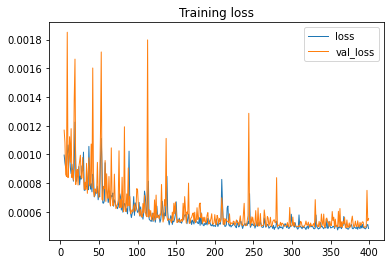

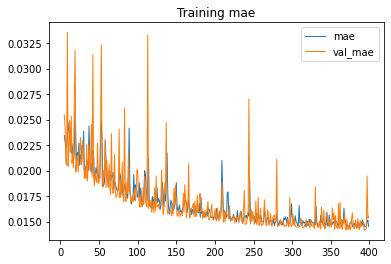

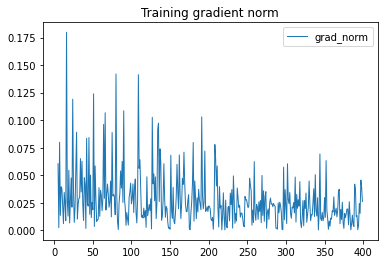

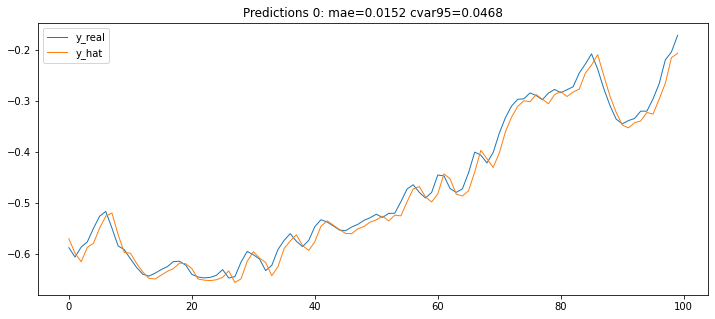

In [156]:
%%time
# Linear 1
# - output: univariate 
# - features: two last ss values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Input((2, 1, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        1, 
        kernel_initializer=tf.keras.initializers.constant(1./2),
        bias_initializer=tf.keras.initializers.zeros(),
        kernel_regularizer=tf.keras.regularizers.L1(0.0001),
    ),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
print(model.summary())
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.1, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.01)

h = train_eval_model(
    model, optimizer, loss, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.996, 10., 300)),
    ],
    board_prefix='ts_uni_linear1',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

(128, 2, 1, 1) (128, 1, 1, 1)
(None, 2, 1, 1) (None, 1, 1, 1)
16/16 [==============================] - 0s 3ms/step - loss: 3.4707e-04 - mae: 0.0142
Train mae 0.0136
Test  mae 0.0142
CPU times: user 4min 48s, sys: 1min 16s, total: 6min 5s
Wall time: 1min 32s


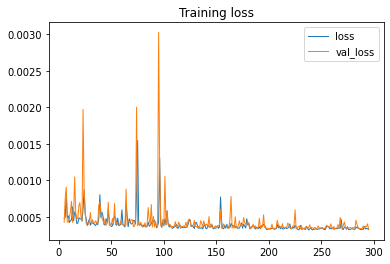

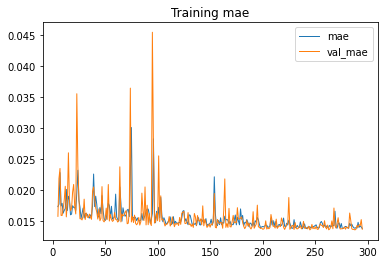

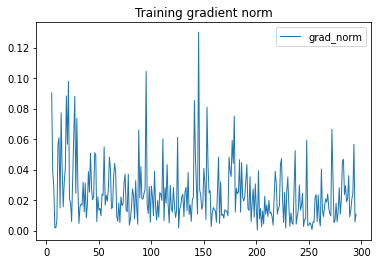

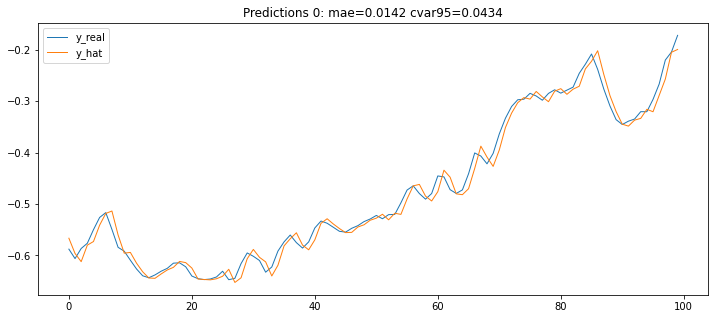

In [155]:
%%time
# Linear 1 Delta
# - output: univariate 
# - features: two last ss values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((2, 1, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.0001), **tf_zero_init_kwargs),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.05, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.01)

h = train_eval_model(
    model, optimizer, loss, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.996, 10., 300)),
    ],
    board_prefix='ts_uni_linear1_delta',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

(128, 4, 1, 2) (128, 1, 1, 1)
(None, 4, 1, 2) (None, 1, 1, 1)
16/16 [==============================] - 0s 3ms/step - loss: 3.0875e-04 - mae: 0.0140
Train mae 0.0133
Test  mae 0.0140
CPU times: user 3min 6s, sys: 48.7 s, total: 3min 55s
Wall time: 58.3 s


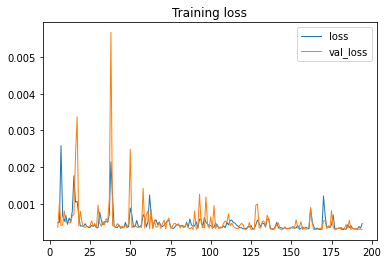

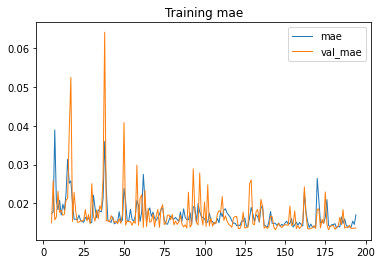

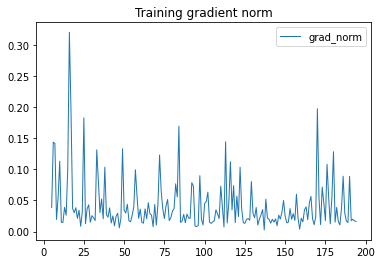

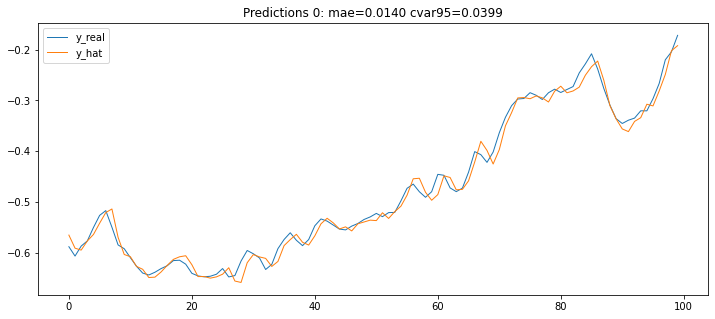

In [152]:
%%time
# Linear 3 Delta
# - output: univariate 
# - features: last 4 ss and ext1 values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], [ext1[:, [0]]], val_ratio=0.2, test_ratio=0.2, 
    feature_window=4, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((4, 1, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.0001), **tf_zero_init_kwargs),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0)
optimizer=tf.keras.optimizers.Adam(0.01)

train_eval_model(
    model, optimizer, loss, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.996, 10., 300)),
    ],
    board_prefix='ts_uni_linear3_delta',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

(128, 12, 1, 3) (128, 1, 1, 1)
(None, 12, 1, 3) (None, 1, 1, 1)
16/16 [==============================] - 0s 3ms/step - loss: 2.1135e-04 - mae: 0.0114
Train mae 0.0109
Test  mae 0.0114
CPU times: user 4min 19s, sys: 1min 8s, total: 5min 28s
Wall time: 1min 21s


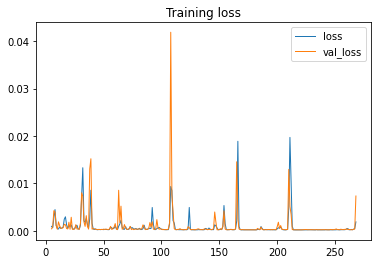

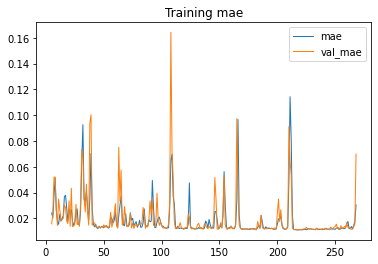

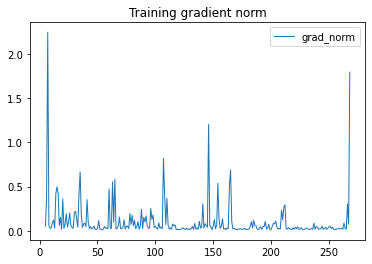

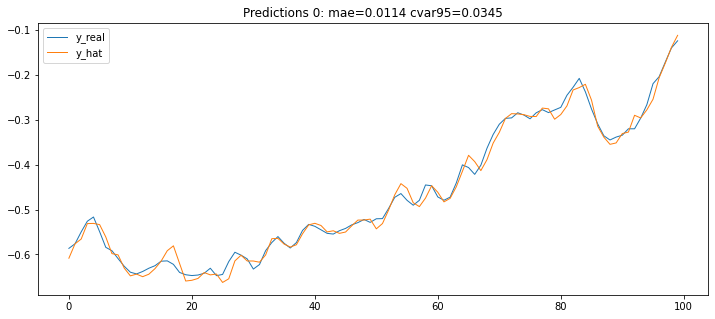

In [153]:
%%time
# Linear 4 Delta
# - output: univariate 
# - features: last 12 ss and ext1+ext2 values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], [ext1[:, [0]], ext2[:, [0]]], val_ratio=0.2, test_ratio=0.2, 
    feature_window=12, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((12, 1, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.0001), **tf_zero_init_kwargs),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0)
optimizer=tf.keras.optimizers.Adam(0.01)

train_eval_model(
    model, optimizer, loss, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.996, 10., 300)),
    ],
    board_prefix='ts_uni_linear4_delta',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

(128, 72, 1, 4) (128, 1, 1, 1)
(None, 72, 1, 4) (None, 1, 1, 1)
16/16 [==============================] - 0s 3ms/step - loss: 2.3344e-04 - mae: 0.0119
Train mae 0.0112
Test  mae 0.0119
CPU times: user 2min 7s, sys: 33.4 s, total: 2min 40s
Wall time: 39.8 s


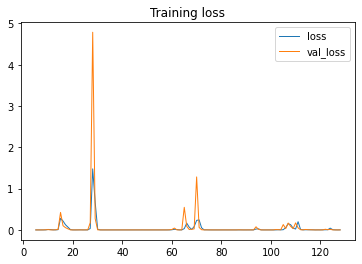

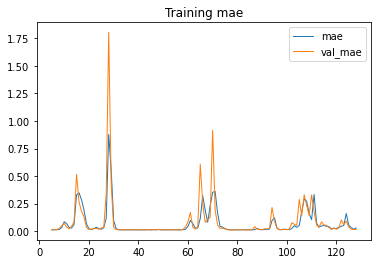

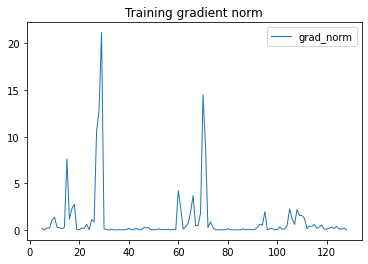

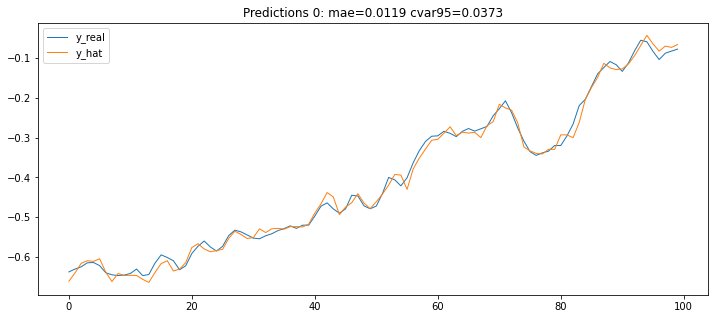

In [154]:
%%time
# Linear 5 Delta
# - output: univariate 
# - features: last 24*3 ss and ext1+ext2+ext3 values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], [ext1[:, [0]], ext2[:, [0]], ext3[:, [0]]], val_ratio=0.2, test_ratio=0.2, 
    feature_window=24*3, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((24*3, 1, 4)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.0001), **tf_zero_init_kwargs),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0)
optimizer=tf.keras.optimizers.Adam(0.01)

train_eval_model(
    model, optimizer, loss, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.996, 10., 300)),
    ],
    board_prefix='ts_uni_linear5_delta',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

#### Feedforward
- As good as linear at best
- Increasing the number of features deteriorated the model

(128, 4, 1, 2) (128, 1, 1, 1)
(None, 4, 1, 2) (None, 1, 1, 1)
Model: "keras_sequential_delta_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_82 (Flatten)         (None, 8)                 0         
_________________________________________________________________
dense_164 (Dense)            (None, 8)                 72        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8)                 0         
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 9         
_________________________________________________________________
reshape_26 (Reshape)         (None, 1, 1, 1)           0         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None
15/15 [==============================] - 0s 3

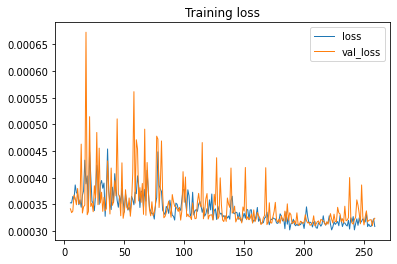

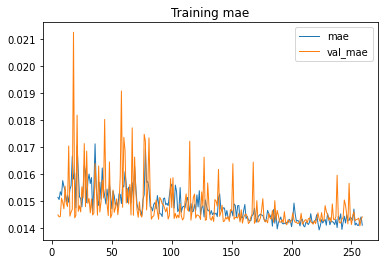

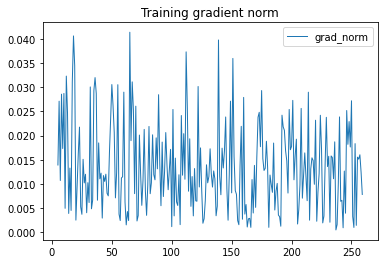

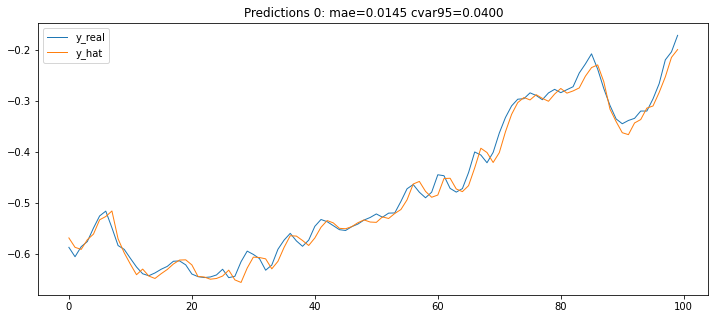

In [46]:
%%time
# Feedforward 1 Delta
# - output: univariate 
# - features: 4 last ss and ext1 values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], [ext1[:, [0]]], val_ratio=0.2, test_ratio=0.2, 
    feature_window=4, label_window=1, label_offset=0, 
    drop_remainder=True,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)

model = KerasSequentialDelta([
    tf.keras.layers.Input((4, 1, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.L2(0.000001)),
    tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.00001), **tf_zero_init_kwargs),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
print(model.summary())
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.05)
optimizer=tf.keras.optimizers.Adam(0.02)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='ts_uni_mlp1_delta',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

(128, 4, 1, 2) (128, 1, 1, 1)
(None, 4, 1, 2) (None, 1, 1, 1)
Model: "keras_model_delta_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 4, 1, 2)]    0                                            
__________________________________________________________________________________________________
lambda_68 (Lambda)              (None, 4, 1, 1)      0           input_22[0][0]                   
__________________________________________________________________________________________________
flatten_69 (Flatten)            (None, 4)            0           lambda_68[0][0]                  
__________________________________________________________________________________________________
dropout_47 (Dropout)            (None, 4)            0           flatten_69[0][0]                 
_________________

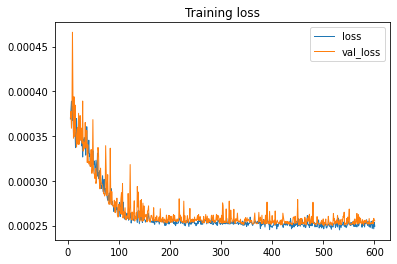

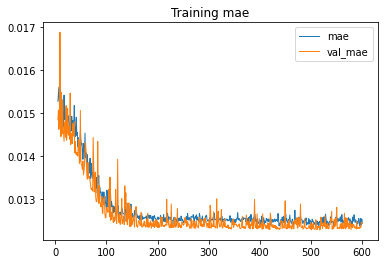

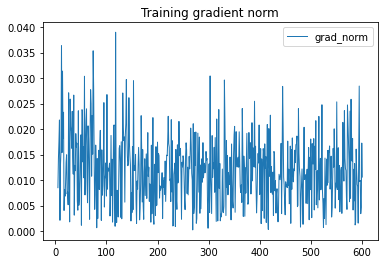

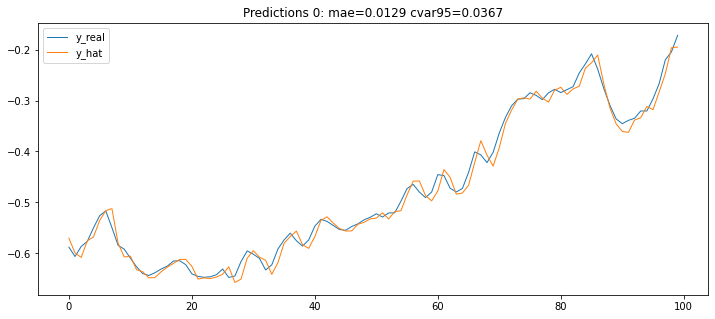

In [41]:
# %%time
# Feedforward 2 Delta
# - output: univariate 
# - features: 2 last ss and 4 last ext1 values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], [ext1[:, [0]]], val_ratio=0.2, test_ratio=0.2, 
    feature_window=4, label_window=1, label_offset=0, 
    drop_remainder=True,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)

i12 = tf.keras.layers.Input((4, 1, 2))
o1 = tf.keras.layers.Lambda(lambda x: x[:, -2:, :, :1])(i12)
o1 = tf.keras.layers.Flatten()(o1)
o1 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o1)

o2 = tf.keras.layers.Lambda(lambda x: x[:, :, :, 1:])(i12)
o2 = tf.keras.layers.Flatten()(o2)
o2 = tf.keras.layers.Dropout(0.2)(o2)
o2 = tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o2)
o2 = tf.keras.layers.PReLU()(o2)
o2 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o2)

o12 = tf.keras.layers.Concatenate(axis=1)([o1, o2])
o12 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.00001), **tf_zero_init_kwargs)(o12)
o12 = tf.keras.layers.Reshape((-1, 1, 1))(o12)

# model = tf.keras.Model(inputs=i12, outputs=o12)
model = KerasModelDelta(inputs=i12, outputs=o12)
print(model.input_shape, model.output_shape)
print(model.summary())
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.05)
optimizer=tf.keras.optimizers.Adam(0.004)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='ts_uni_mlp2_delta',
    n_epoch=1000,
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

(128, 12, 1, 3) (128, 1, 1, 1)
(None, 12, 1, 3) (None, 1, 1, 1)
Model: "keras_model_delta_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 12, 1, 3)]   0                                            
__________________________________________________________________________________________________
lambda_70 (Lambda)              (None, 4, 1, 1)      0           input_23[0][0]                   
__________________________________________________________________________________________________
lambda_71 (Lambda)              (None, 12, 1, 1)     0           input_23[0][0]                   
__________________________________________________________________________________________________
flatten_71 (Flatten)            (None, 4)            0           lambda_70[0][0]                  
_______________

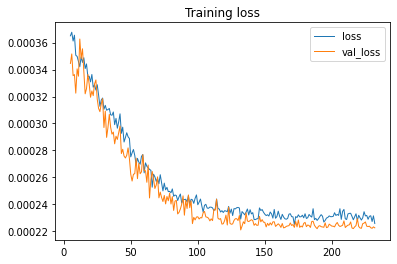

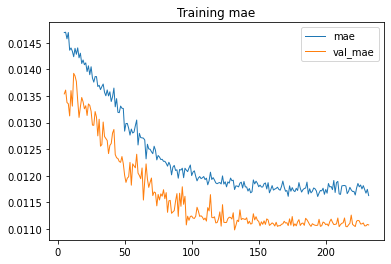

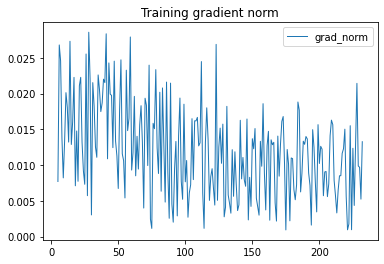

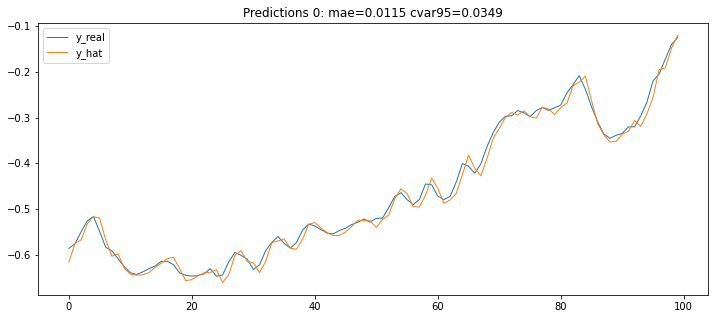

In [42]:
%%time
# Feedforward 3 Delta
# - output: univariate 
# - features: two last ss, 4 ext1 and 12 ext2 values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], [ext1[:, [0]], ext2[:, [0]]], val_ratio=0.2, test_ratio=0.2, 
    feature_window=12, label_window=1, label_offset=0, 
    drop_remainder=True,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)

i12 = tf.keras.layers.Input((12, 1, 3))
o1 = tf.keras.layers.Lambda(lambda x: x[:, -2:, :, :1])(i12)
o1 = tf.keras.layers.Flatten()(o1)
o1 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o1)

o2 = tf.keras.layers.Lambda(lambda x: x[:, -4:, :, 1:2])(i12)
o2 = tf.keras.layers.Flatten()(o2)
o2 = tf.keras.layers.Dropout(0.5)(o2)
o2 = tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o2)
o2 = tf.keras.layers.PReLU()(o2)
o2 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o2)

o3 = tf.keras.layers.Lambda(lambda x: x[:, :, :, 2:])(i12)
o3 = tf.keras.layers.Flatten()(o3)
o3 = tf.keras.layers.Dropout(0.5)(o3)
o3 = tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o3)
o3 = tf.keras.layers.PReLU()(o3)
o3 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o3)

o12 = tf.keras.layers.Concatenate(axis=1)([o1, o2, o3])
o12 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.00001), **tf_zero_init_kwargs)(o12)
o12 = tf.keras.layers.Reshape((-1, 1, 1))(o12)

# model = tf.keras.Model(inputs=i12, outputs=o12)
model = KerasModelDelta(inputs=i12, outputs=o12)
print(model.input_shape, model.output_shape)
print(model.summary())
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.05)
optimizer=tf.keras.optimizers.Adam(0.0015)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
        
    ],
    board_prefix='ts_uni_mlp3_delta',
    n_epoch=1000,
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

(128, 72, 1, 4) (128, 1, 1, 1)
(None, 72, 1, 4) (None, 1, 1, 1)
Model: "keras_model_delta_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 72, 1, 4)]   0                                            
__________________________________________________________________________________________________
lambda_89 (Lambda)              (None, 4, 1, 1)      0           input_30[0][0]                   
__________________________________________________________________________________________________
lambda_90 (Lambda)              (None, 12, 1, 1)     0           input_30[0][0]                   
__________________________________________________________________________________________________
lambda_91 (Lambda)              (None, 72, 1, 1)     0           input_30[0][0]                   
_______________

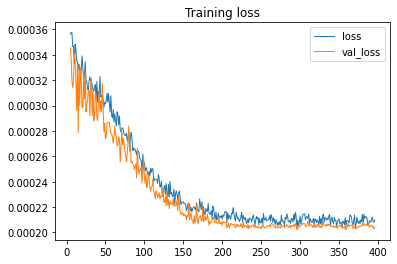

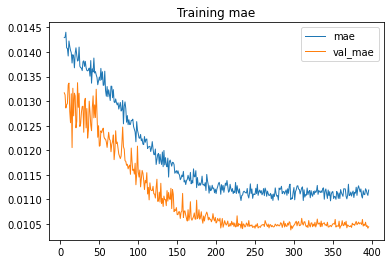

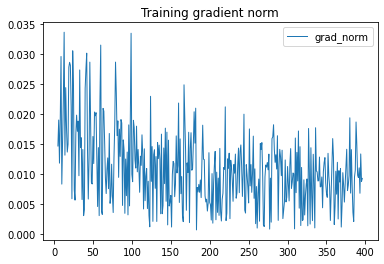

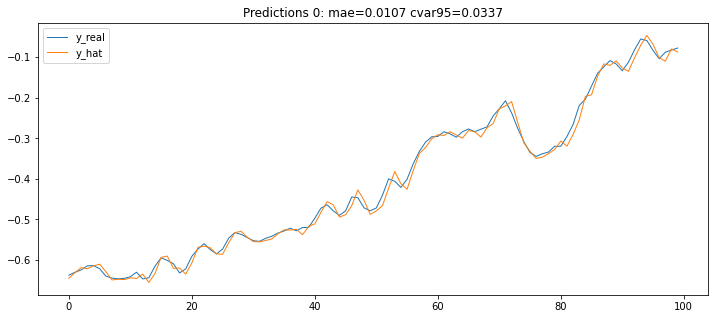

In [49]:
%%time
# Feedforward 4 Delta
# - output: univariate 
# - features: two last ss, 4 ext1, 12 ext2 and 24*3 ext3 values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], [ext1[:, [0]], ext2[:, [0]], ext3[:, [0]]], val_ratio=0.2, test_ratio=0.2, 
    feature_window=24*3, label_window=1, label_offset=0, 
    drop_remainder=True,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)

i12 = tf.keras.layers.Input((24*3, 1, 4))
o1 = tf.keras.layers.Lambda(lambda x: x[:, -2:, :, :1])(i12)
o1 = tf.keras.layers.Flatten()(o1)
o1 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o1)

o2 = tf.keras.layers.Lambda(lambda x: x[:, -4:, :, 1:2])(i12)
o2 = tf.keras.layers.Flatten()(o2)
o2 = tf.keras.layers.Dropout(0.5)(o2)
o2 = tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o2)
o2 = tf.keras.layers.PReLU()(o2)
o2 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o2)

o3 = tf.keras.layers.Lambda(lambda x: x[:, -12:, :, 2:3])(i12)
o3 = tf.keras.layers.Flatten()(o3)
o3 = tf.keras.layers.Dropout(0.5)(o3)
o3 = tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o3)
o3 = tf.keras.layers.PReLU()(o3)
o3 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o3)

o4 = tf.keras.layers.Lambda(lambda x: x[:, :, :, 3:])(i12)
o4 = tf.keras.layers.Flatten()(o4)
o4 = tf.keras.layers.Dropout(0.5)(o4)
o4 = tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o4)
o4 = tf.keras.layers.PReLU()(o4)
o4 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o4)

o12 = tf.keras.layers.Concatenate(axis=1)([o1, o2, o3, o4])
o12 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.00001), **tf_zero_init_kwargs)(o12)
o12 = tf.keras.layers.Reshape((-1, 1, 1))(o12)

# model = tf.keras.Model(inputs=i12, outputs=o12)
model = KerasModelDelta(inputs=i12, outputs=o12)
print(model.input_shape, model.output_shape)
print(model.summary())
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.05)
optimizer=tf.keras.optimizers.Adam(0.002)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 250)),
    ],
    board_prefix='ts_uni_mlp4_delta',
    n_epoch=1000,
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

#### CNN

In [10]:
# CNN models can work with input of varying length
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.Conv1D(filters=4, kernel_size=(4,), strides=1, padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1),
])

print('--- Forecast 1 value ---')
x = tf.convert_to_tensor([1., 2., 3., 4.])
print(x.shape)
print(model(x[tf.newaxis, :]))

print('\n--- Forecast 3 values ---')
x = tf.convert_to_tensor([1., 2., 3., 4., 5., 6.])
print(x.shape)
print(model(x[tf.newaxis, :]))

--- Forecast 1 value ---
(4,)
tf.Tensor([[[0.67006326]]], shape=(1, 1, 1), dtype=float32)

--- Forecast 3 values ---
(6,)
tf.Tensor(
[[[0.67006326]
  [0.99363506]
  [1.3172069 ]]], shape=(1, 3, 1), dtype=float32)


(128, 2, 1, 1) (128, 1, 1, 1)
(None, 2, 1, 1) (None, 1, 1, 1)
16/16 [==============================] - 0s 3ms/step - loss: 3.0548e-04 - mae: 0.0138
Train mae 0.0132
Test  mae 0.0138
CPU times: user 6min 21s, sys: 1min 40s, total: 8min 2s
Wall time: 2min 2s


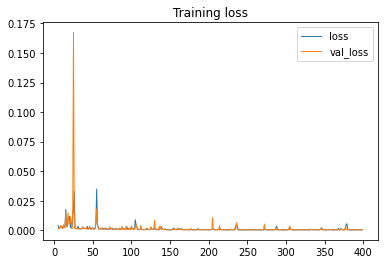

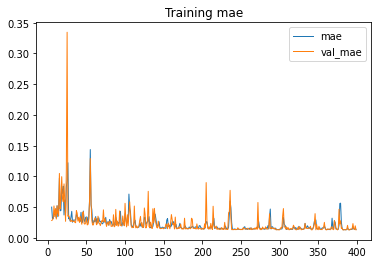

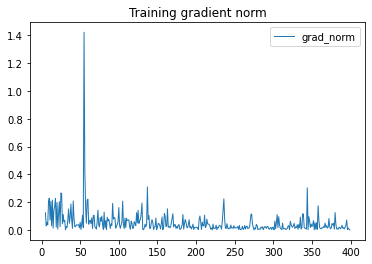

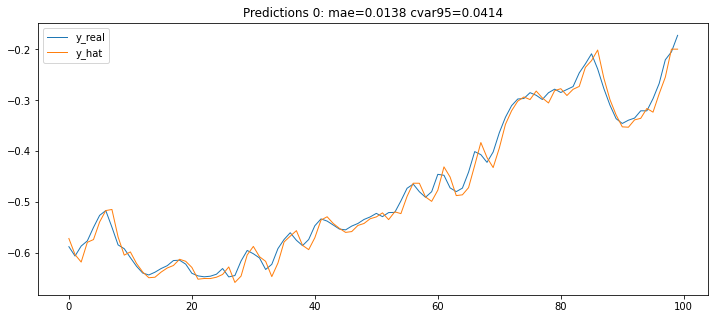

In [72]:
%%time
# CNN 1
# - output: univariate 
# - features: two last ss values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Input((2, 1, 1)),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=1, kernel_size=(2, 1), strides=1, padding='valid'),
#     tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.1)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='ts_uni_cnn1',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

(128, 2, 1, 1) (128, 1, 1, 1)
(None, 2, 1, 1) (None, 1, 1, 1)
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
16/16 [==============================] - 0s 3ms/step - loss: 3.3090e-04 - mae: 0.0143
Train mae 0.0137
Test  mae 0.0143
CPU times: user 1min 49s, sys: 28.3 s, total: 2min 17s
Wall time: 37.6 s


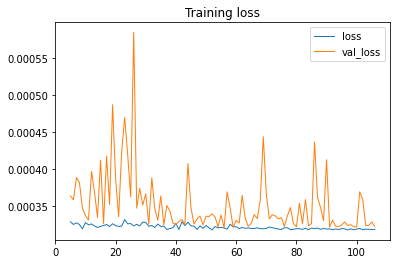

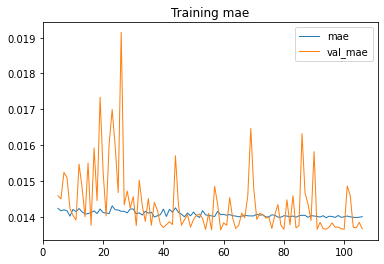

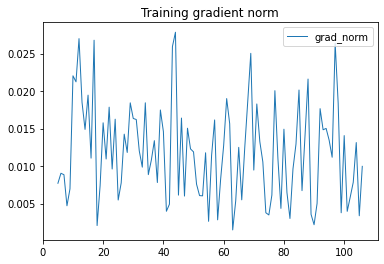

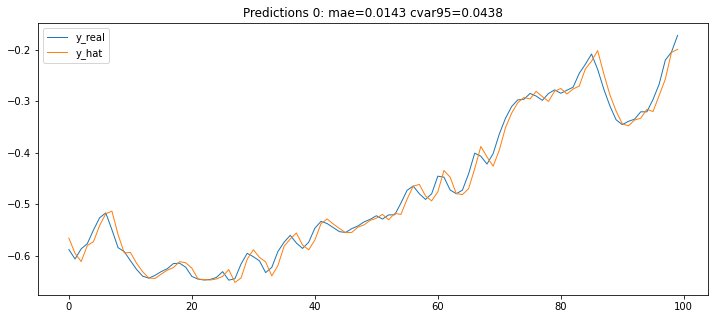

In [16]:
%%time
# CNN 1 Delta
# - output: univariate 
# - features: two last ss values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((2, 1, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99),
    tf.keras.layers.Conv2D(filters=1, kernel_size=(2, 1), strides=1, padding='valid', 
                           kernel_regularizer=tf.keras.regularizers.L2(0.00001),
                           **tf_zero_init_kwargs),
#     tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.002)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.98, 10., 100)),
    ],
    board_prefix='ts_uni_cnn1_delta',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

(128, 2, 32, 1) (128, 1, 32, 1)
(None, 2, 32, 1) (None, 1, 32, 1)
Model: "keras_sequential_delta_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_20 (Batc (None, 2, 32, 1)          128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 32, 1)          3         
Total params: 131
Trainable params: 67
Non-trainable params: 64
_________________________________________________________________
None


16/16 [==============================] - 0s 3ms/step - loss: 4.0273e-04 - mae: 0.0152
Train mae 0.0152
Test  mae 0.0152


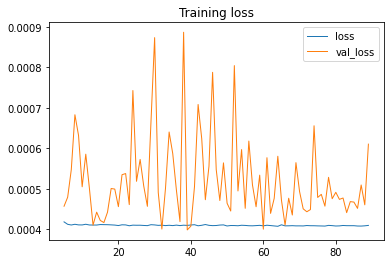

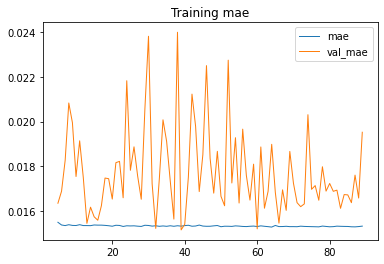

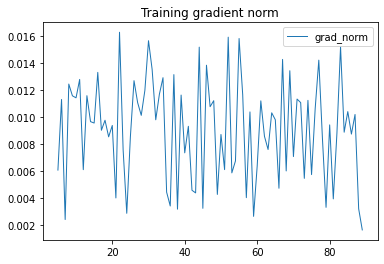

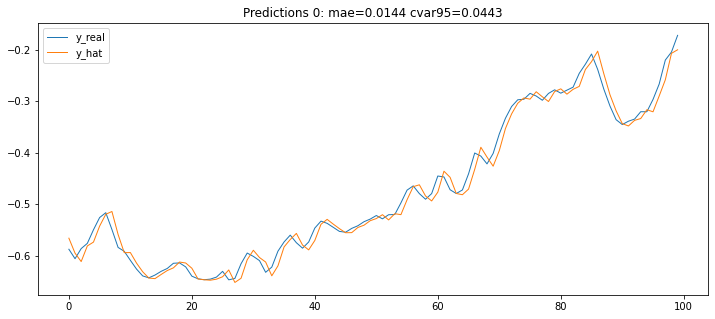

In [24]:
# %%time
# CNN 1 Delta
# - output: multivariate 
# - features: two last ss values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, :], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((2, 32, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1]),
    tf.keras.layers.Conv2D(filters=1, kernel_size=(2, 1), strides=1, padding='valid', 
                           kernel_regularizer=tf.keras.regularizers.L2(0.00001),
                           **tf_zero_init_kwargs),
#     tf.keras.layers.Lambda(lambda x: tf.concat([x[:, :, -1:, :], x, x[:, :, :1, :]], axis=2)),
#     tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 3), strides=1, padding='valid', **tf_zero_init_kwargs),
#     tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1]),
#     tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.00001),
#                            **tf_zero_init_kwargs),
])
print(model.input_shape, model.output_shape)
print(model.summary())

loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.001)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='ts_multi_cnn1_delta',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

(128, 2, 32, 1) (128, 1, 32, 1)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method ParallelLayer2.call of <__main__.ParallelLayer2 object at 0x7f5161008df0>>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <bound method ParallelLayer2.call of <__main__.P

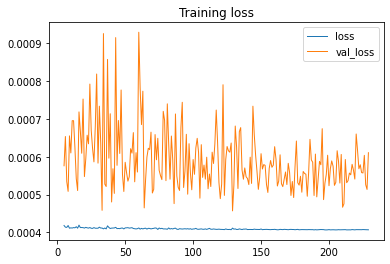

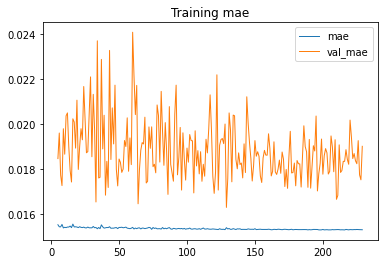

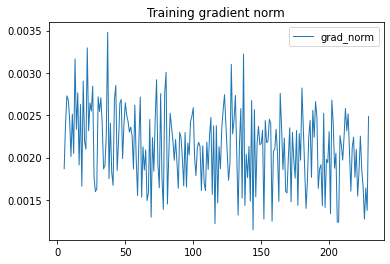

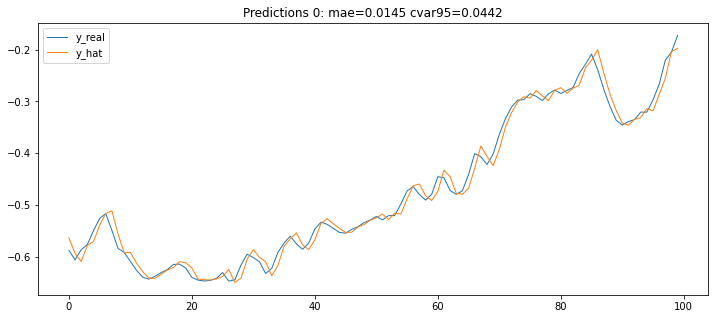

In [20]:
%%time
# CNN 1.1 Delta
# - output: multivariate
# - features: two last ss values
# - separate convolutions
def _series_splitter(x):
    return [x[:,:,i,:] for i in range(x.shape[2])]

class ParallelLayer2(tf.keras.layers.Layer):
    def __init__(self, layer_lambda, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_lambda = layer_lambda
        
        self.splits = tf.keras.layers.Lambda(_series_splitter)
        self.layers = []
        self.reshape = tf.keras.layers.Lambda(lambda x: x[:, :, tf.newaxis, :])
        self.concat = tf.keras.layers.Concatenate(axis=2)
        
    def build(self, input_shape):
        self.layers = [self.layer_lambda() for _ in range(input_shape[2])]
        
#     @tf.autograph.experimental.do_not_convert
    def call(self, input_tensor, training=False):
        o = self.splits(input_tensor)
        o = [layer(o_) for layer, o_ in zip(self.layers, o)]
        o = [self.reshape(o_) for o_ in o]
        o = self.concat(o)

        return o
    
#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], input_shape[1], input_shape[2], 1)
    
    def get_config(self):
        return {'layer_lambda': self.layer_lambda}


train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, :], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((2, 32, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1]),
    ParallelLayer2(lambda: tf.keras.layers.Conv1D(filters=1, kernel_size=2, strides=1, padding='valid', **tf_zero_init_kwargs)),
#     tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 3), strides=1, padding='same', **tf_zero_init_kwargs),
])
print(model.input_shape, model.output_shape)
print(model.summary())

loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.0018)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='ts_multi_cnn1_1_delta',
    n_epoch=1000,
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

(128, 72, 1, 4) (128, 1, 1, 1)
(None, 72, 1, 4) (None, 1, 1, 1)
Model: "keras_model_delta_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 72, 1, 4)]   0                                            
__________________________________________________________________________________________________
lambda_110 (Lambda)             (None, 72, 1, 1)     0           input_40[0][0]                   
__________________________________________________________________________________________________
batch_normalization_152 (BatchN (None, 72, 1, 1)     4           lambda_110[0][0]                 
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 18, 1, 8)     40          batch_normalization_152[0][0]    
_______________

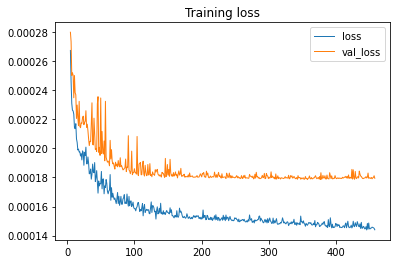

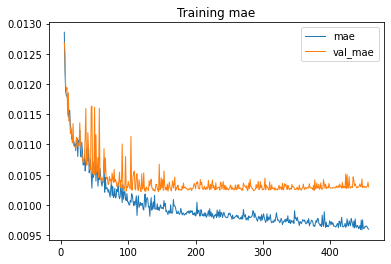

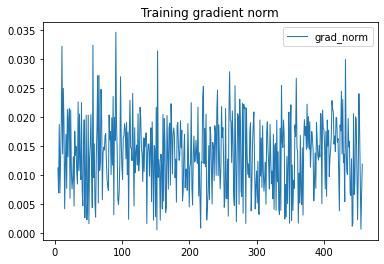

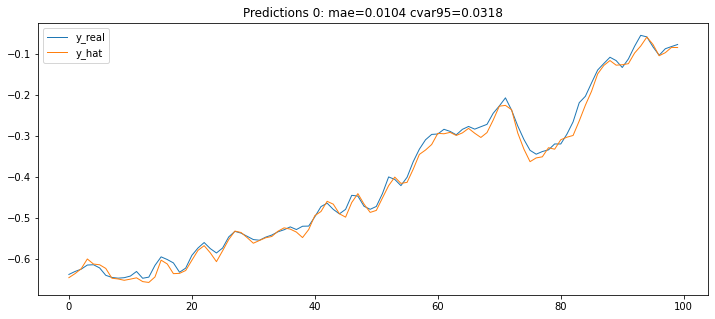

In [52]:
%%time
# CNN 2 Delta
# - output: univariate 
# - features: two last ss, 4 ext1, 12 ext2 and 24*3 ext3 values
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], [ext1[:, [0]], ext2[:, [0]], ext3[:, [0]]], val_ratio=0.2, test_ratio=0.2, 
    feature_window=24*3, label_window=1, label_offset=0, 
    drop_remainder=True,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)

i = tf.keras.layers.Input((24*3, 1, 4))
o1 = tf.keras.layers.Lambda(lambda x: x[:, -2:, :, :1])(i)
o1 = tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1])(o1)
o1 = tf.keras.layers.Conv2D(filters=1, kernel_size=(2, 1), strides=1, padding='valid', **tf_zero_init_kwargs)(o1)

o2 = tf.keras.layers.Lambda(lambda x: x[:, -4:, :, 1:2])(i)
o2 = tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1])(o2)
o2 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 1), strides=4, padding='valid')(o2)
o2 = tf.keras.layers.PReLU()(o2)
o2 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o2)

o3 = tf.keras.layers.Lambda(lambda x: x[:, -12:, :, 2:3])(i)
o3 = tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1])(o3)
o3 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 1), strides=4, padding='valid')(o3)
o3 = tf.keras.layers.PReLU()(o3)
o3 = tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1])(o3)
o3 = tf.keras.layers.Conv2D(filters=8, groups=4, kernel_size=(3, 1), strides=3, padding='valid')(o3)
o3 = tf.keras.layers.PReLU()(o3)
o3 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o3)

o4 = tf.keras.layers.Lambda(lambda x: x[:, :, :, 3:4])(i)
o4 = tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1])(o4)
o4 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 1), strides=4, padding='valid')(o4)
o4 = tf.keras.layers.PReLU()(o4)
o4 = tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1])(o4)
o4 = tf.keras.layers.Conv2D(filters=8, groups=4, kernel_size=(6, 1), strides=6, padding='valid')(o4)
o4 = tf.keras.layers.PReLU()(o4)
o4 = tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1])(o4)
o4 = tf.keras.layers.Conv2D(filters=8, groups=4, kernel_size=(3, 1), strides=3, padding='valid')(o4)
o4 = tf.keras.layers.PReLU()(o4)
o4 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001))(o4)

o = tf.keras.layers.Concatenate(axis=-1)([o1, o2, o3, o4])
o = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(0.000001), **tf_zero_init_kwargs)(o)
o = tf.keras.layers.Reshape((-1, 1, 1))(o)

model = KerasModelDelta(inputs=i, outputs=o)
print(model.input_shape, model.output_shape)
print(model.summary())
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.Adam(0.002)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='ts_uni_cnn2_delta',
    n_epoch=1000,
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

#### CNN Sequences
- Mathematically, equivalent to CNN
- Can be quicker as multiple values are pulled at once

46 15 15
(4, 34, 1, 1) (4, 33, 1, 1)
(None, 34, 1, 1) (None, 33, 1, 1)
Model: "keras_sequential_delta_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 34, 1, 1)          4         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 1, 1)          3         
Total params: 7
Trainable params: 5
Non-trainable params: 2
_________________________________________________________________
None
15/15 [==============================] - 0s 1ms/step - loss: 3.3740e-04 - mae: 0.0144
Train mae 0.0138
Test  mae 0.0144
CPU times: user 25.1 s, sys: 2.83 s, total: 27.9 s
Wall time: 15.9 s


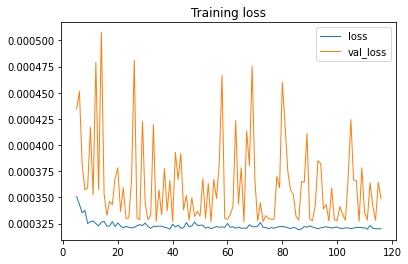

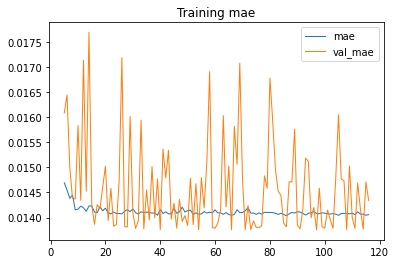

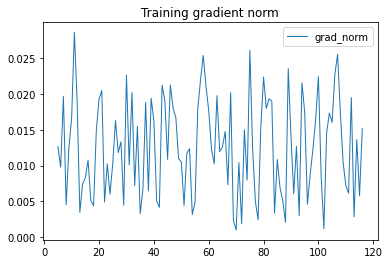

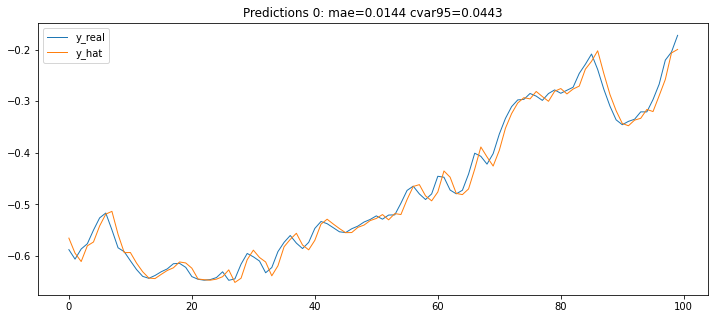

In [12]:
%%time
# CNN 1 Sequences
# - output: univariate 
# - features: two last ss values
w = 32
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2+w, label_window=1+w, label_offset=0-w, 
    batch_size=4,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((2+w, 1, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99),
    tf.keras.layers.Conv2D(filters=1, kernel_size=(2, 1), strides=1, padding='valid',
                           kernel_regularizer=tf.keras.regularizers.L2(0.000001),
                           **tf_zero_init_kwargs),
#     tf.keras.layers.TimeDistributed(tf.keras.layers),
])

print(model.input_shape, model.output_shape)
print(model.summary())
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.Adam(0.001)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='ts_uni_cnn1_seq', 
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

46 15 15
(4, 34, 32, 1) (4, 33, 32, 1)
(None, 34, 32, 1) (None, 33, 32, 1)
Model: "keras_sequential_delta_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_18 (Batc (None, 34, 32, 1)         128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 33, 32, 1)         3         
Total params: 131
Trainable params: 67
Non-trainable params: 64
_________________________________________________________________
None


15/15 [==============================] - 0s 808us/step - loss: 4.0542e-04 - mae: 0.0153
Train mae 0.0153
Test  mae 0.0153
CPU times: user 15.6 s, sys: 1.79 s, total: 17.4 s
Wall time: 9.5 s


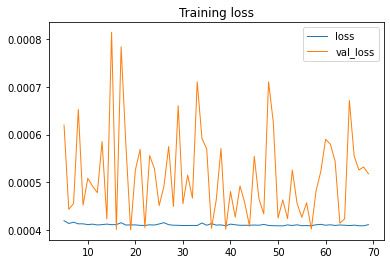

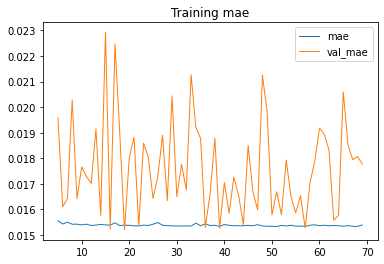

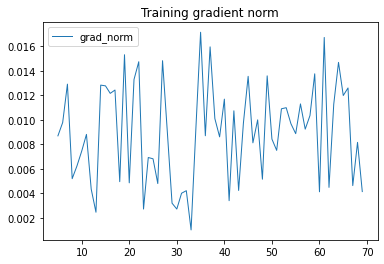

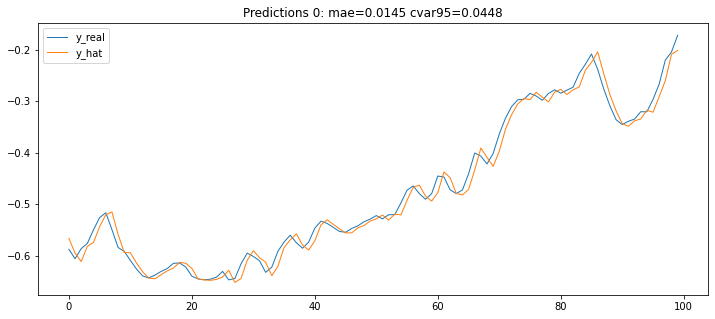

In [22]:
%%time
# CNN 1 Sequences Multivariate
# - output: multivariate 
# - features: two last ss values
w = 32
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, :], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2+w, label_window=1+w, label_offset=0-w, 
    batch_size=4,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((2+w, 32, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1]),
    tf.keras.layers.Conv2D(filters=1, kernel_size=(2, 1), strides=1, padding='valid',
                           kernel_regularizer=tf.keras.regularizers.L2(0.00001),
                           **tf_zero_init_kwargs),
#     tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 2), strides=1, padding='same'),
#     tf.keras.layers.BatchNormalization(momentum=0.99, renorm_momentum=0.99, axis=[-2, -1]),
])
print(model.input_shape, model.output_shape)
print(model.summary())
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.001)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_multi_cnn1_seq', 
    n_epoch=1000,
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

#### RNN
- Empirically, RNN is harder to fit well than CNN
- Optimization is more stable if delta values are used 

In [85]:
# RNN models can output one or all forecasted values at once
print('--- Output last forecasted value ---')
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(1, return_sequences=False),
])
x = tf.convert_to_tensor([1., 2., 3., 4.])
print(x.shape)
print(model(x[tf.newaxis, :]))

print('\n--- Output all forecasted values ---')
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(1, return_sequences=True),
])
x = tf.convert_to_tensor([1., 2., 3., 4.])
print(x.shape)
print(model(x[tf.newaxis, :]))

--- Output last forecasted value ---
(4,)
tf.Tensor([[0.7241248]], shape=(1, 1), dtype=float32)

--- Output all forecasted values ---
(4,)
tf.Tensor(
[[[0.83678883]
  [0.9192151 ]
  [0.9912177 ]
  [0.9990952 ]]], shape=(1, 4, 1), dtype=float32)


In [86]:
print('--- Return output only ---')
input_layer = tf.keras.layers.Input(shape=(None, 1))
cl = tf.keras.layers.Reshape((-1, 1))(input_layer)
output_layer = tf.keras.layers.SimpleRNN(1)(cl)
model = tf.keras.Model([input_layer], output_layer)
x = tf.convert_to_tensor([1., 2., 3., 4.])
print(model(x[tf.newaxis, :]))

print('\n--- Return output and state (the same for SimpleRNN) ---')
input_layer = tf.keras.layers.Input(shape=(None, 1))
cl = tf.keras.layers.Reshape((-1, 1))(input_layer)
output_layer = tf.keras.layers.SimpleRNN(1, return_state=True)(cl)
model = tf.keras.Model([input_layer], output_layer)
x = tf.convert_to_tensor([1., 2., 3., 4.])
print(model(x[tf.newaxis, :]))

print('\n--- Return output and state (the same for GRU) ---')
input_layer = tf.keras.layers.Input(shape=(None, 1))
cl = tf.keras.layers.Reshape((-1, 1))(input_layer)
output_layer = tf.keras.layers.GRU(1, return_state=True)(cl)
model = tf.keras.Model([input_layer], output_layer)
x = tf.convert_to_tensor([1., 2., 3., 4.])
print(model(x[tf.newaxis, :]))

print('\n--- Return output and state (LSTM) ---')
input_layer = tf.keras.layers.Input(shape=(None, 1))
cl = tf.keras.layers.Reshape((-1, 1))(input_layer)
output_layer = tf.keras.layers.LSTM(1, return_state=True)(cl)
model = tf.keras.Model([input_layer], output_layer)
x = tf.convert_to_tensor([1., 2., 3., 4.])
print(model(x[tf.newaxis, :]))

--- Return output only ---
tf.Tensor([[-0.9991616]], shape=(1, 1), dtype=float32)

--- Return output and state (the same for SimpleRNN) ---


KeyboardInterrupt: 

In [ ]:
# RNN models can work with input of varying length

# TODO: create an autoregressive model


In [ ]:
%%time
# RNN 1
# - output: univariate 
# - features: last ss value
# - batch size = 16 
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=1, label_window=1, label_offset=0, 
    shuffle_train=True, shuffle_val=True,
    batch_size=16, drop_remainder=True,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Input((1,1,1)),
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(4),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.01)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn1',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

In [ ]:
%%time
# RNN 2
# - output: univariate 
# - features: last ss value
# - batch size = 16 
# - stateful
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=1, label_window=1, label_offset=0, 
    shuffle_train=False, shuffle_val=False, 
    batch_size=16, drop_remainder=True,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Input((1,1,1), batch_size=16),
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(4, stateful=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.01)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn2',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

In [ ]:
%%time
# RNN 3
# - output: univariate 
# - features: last ss value
# - batch size = 256
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=1, label_window=1, label_offset=0, 
    shuffle_train=True, shuffle_val=True, 
    batch_size=256, drop_remainder=True,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Input((1,1,1)),
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(4, stateful=False),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.04)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn3',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

In [ ]:
%%time
# RNN 3 Delta
# - output: univariate 
# - features: last ss value
# - batch size = 256
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=1, label_window=1, label_offset=0, 
    shuffle_train=True, shuffle_val=True, 
    batch_size=256, drop_remainder=True,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((1,1,1)),
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(4, stateful=False),
    tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.zeros(), bias_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.01)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn3_delta',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

In [ ]:
%%time
# RNN 3
# - output: multivariate 
# - features: last ss value
# - batch size = 256
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, :], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=1, label_window=1, label_offset=0, 
    shuffle_train=True, shuffle_val=True, 
    batch_size=256, drop_remainder=True,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Input((1,32,1)),
    tf.keras.layers.Reshape((1, 32)),
    tf.keras.layers.SimpleRNN(32*4, stateful=False),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Reshape((1, 32, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.04)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_multi_rnn3',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

In [ ]:
%%time
# RNN 4
# - output: univariate 
# - features: two last ss values
# - batch size = 16 
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0, 
    shuffle_train=True, shuffle_val=True,
    batch_size=16, drop_remainder=True,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Input((2,1,1)),
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(4),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.04)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn4',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

In [ ]:
%%time
# RNN 4 Delta
# - output: univariate 
# - features: two last ss values
# - batch size = 16 
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0, 
    shuffle_train=True, shuffle_val=True,
    batch_size=16, drop_remainder=True,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((2,1,1)),
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(4),
    tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.zeros(), bias_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.01)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn4_delta',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

In [ ]:
%%time
# RNN 4
# - output: multivariate 
# - features: last ss value
# - batch size = 256
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, :], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0, 
    shuffle_train=True, shuffle_val=True, 
    batch_size=256, drop_remainder=True,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((2,32,1)),
    tf.keras.layers.Reshape((2, 32)),
    tf.keras.layers.SimpleRNN(32*4, stateful=False),
    tf.keras.layers.Dense(32, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape((1, 32, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.01)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_multi_rnn4',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

In [ ]:
%%time
# RNN 6
# - output: univariate 
# - features: two last ss values
# - batch size = 256 
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0, 
    shuffle_train=True, shuffle_val=True,
    batch_size=256, drop_remainder=True,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Input((2,1,1)),
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(4),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.04)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn6',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

In [ ]:
%%time
# RNN 6 Delta
# - output: univariate 
# - features: two last ss values
# - batch size = 256 
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0, 
    shuffle_train=True, shuffle_val=True,
    batch_size=256, drop_remainder=True,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequentialDelta([
    tf.keras.layers.Input((2, 1, 1)),
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(4),
    tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.zeros(), bias_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.02)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn6_delta',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

In [ ]:
%%time
# RNN 6
# - output: multivariate 
# - features: two last ss values
# - batch size = 256 
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, :], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=2, label_window=1, label_offset=0, 
    shuffle_train=True, shuffle_val=True,
    batch_size=256, drop_remainder=True,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Input((2,32,1)),
    tf.keras.layers.Reshape((2, 32)),
    tf.keras.layers.SimpleRNN(4*32),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Reshape((1, 32, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.04)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_multi_rnn6',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

In [ ]:
%%time
# RNN 7
# - output: univariate 
# - features: 24 last ss values
# - batch size = 256 
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=24, label_window=1, label_offset=0, 
    shuffle_train=True, shuffle_val=True,
    batch_size=256, drop_remainder=True,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Input((24,1,1)),
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(4),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.04)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn7',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

#### RNN Sequences
- Equivalent to RNN with one feature (?)
- ...

In [ ]:
%%time
# RNN 3 Sequences
# - output: univariate 
# - features: last ss value
# - batch size = 256
# - return sequences
w = 256
train_ds, val_ds, test_ds = make_ts_datasets(
    ss[:, [0]], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=w, label_window=w, label_offset=1-w, 
    shuffle_train=True, shuffle_val=True, 
    batch_size=1, drop_remainder=True,
)
print(len(train_ds), len(val_ds), len(test_ds))
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Input((w,1,1)),
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(4, stateful=False, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape((-1, 1, 1)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
# optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)
optimizer=tf.keras.optimizers.Adam(0.02)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn3_seq',
)
plot_predictions(model, test_ds, first_idx=0, last_idx=100)

#### LSTM

In [ ]:
%%time
# RNN 2
# - output: univariate 
# - features: multiple jump values (window=30*24)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(30*24,)),
    tf.keras.layers.SimpleRNN(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn2',
)

In [ ]:
%%time
# RNN 3
# - output: univariate 
# - features: multiple jump values (window=30*24)
# - cell: LSTM
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(30*24,)),
    tf.keras.layers.LSTM(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn3',
)

In [ ]:
%%time
# RNN 4
# - output: univariate 
# - features: multiple jump values (window=30*24)
# - cell: GRU
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(30*24,)),
    tf.keras.layers.GRU(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn4',
)

In [ ]:
%%time
# RNN 5
# - output: univariate 
# - features: multiple jump values (window=30*24)
# - cell: GRU (16-unit state)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(30*24,)),
    tf.keras.layers.GRU(16),
    tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn5',
)

In [ ]:
%%time
# RNN 6
# - output: univariate 
# - features: multiple jump and ext values (window=30*24)
# - cell: GRU (4 units)
# TODO: improve convergence
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], ext[:, 0], val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
#     tf.keras.layers.Reshape((-1, 1), input_shape=(30*24,)),
    tf.keras.layers.GRU(4, input_shape=(30*24, 2)),
    tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.02, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn6',
)

In [ ]:
%%time
# RNN 7
# - output: univariate 
# - features: multiple jump and ext values (window=30*24)
# - cell: GRU (4 units) + LeakyReLU
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], ext[:, 0], val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.GRU(4, input_shape=(30*24, 2)),
    tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.02, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn7',
)

### Multivariate

#### Baseline: last value

In [ ]:
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps, None, val_ratio=0.1, test_ratio=0.3, 
    feature_window=1, label_window=1, label_offset=0, 
    normalize=False,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)

class Baseline(tf.keras.Model):
    def call(self, inputs):
        return inputs
    
baseline = Baseline()
baseline.compile(loss=tf.losses.MSE, metrics=['mae'])
baseline.evaluate(train_ds.batch(128))
baseline.evaluate(test_ds.batch(128))
_=_

#### TF2 RNN

In [ ]:
%%time
# RNN 5
# - output: univariate 
# - features: multiple jump values (window=30*24)
# - cell: GRU (16-unit state)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps, None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.GRU(16, input_shape=(30*24, 32,)),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Reshape((1, -1,)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_multi_rnn1',
)